In [1]:
using HDF5
using JSON

using Plots, LinearAlgebra, Statistics, Random, StatsBase, Compat, Distributions

data = Dict()

# filenames = ["./result_1_9.hdf5", "./result_10_29.hdf5", "./result_30_49.hdf5",
# "./result_50_69.hdf5", "./result_70_89.hdf5", "./result_90_109.hdf5",
# "./result_110_129.hdf5", "./result_130_150.hdf5"];
filenames = ["mcmc_1_69.hdf5", "mcmc_70_99.hdf5", "mcmc_100_119.hdf5", "mcmc_120_139.hdf5", "mcmc_140_150.hdf5"]



d = Normal(0, 5)
data_samples = Array{Float64, 1}()
counter = 0
while counter < 10000
    x = rand(d)
    if abs(x) <= 30.5
        counter += 1
        push!(data_samples, convert(Int, round(x)))
    end
end
u=unique(data_samples)
thetas=Dict([(i,count(x->x==i,data_samples)) for i in u])

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")
    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [elem.data[1] for elem in read(m)["deposit"]]
        energy_value = convert(Int, j["values"]["macros"]["energy"])
        theta = convert(Int, j["values"]["macros"]["theta"])
        if !haskey(data, energy_value)
            data[energy_value] = []
        end
        if haskey(thetas, theta)
            append!(data[energy_value], data_array[1:thetas[theta]])
        end
    end
    close(ligo)
end

for energy in keys(data)
    Random.shuffle!(data[energy])
end

mcmc_1_69.hdf5
mcmc_70_99.hdf5
mcmc_100_119.hdf5
mcmc_120_139.hdf5
mcmc_140_150.hdf5


In [2]:
include("../../statreg_materials/StatReg.jl/src/StatReg.jl")
using .StatReg

plotly()
gr(size=(500,500), html_output_format=:png)

GLOBAL_RNG = 123
Random.seed!(123);

In [3]:
using Memoize
@memoize function K(E, y)
    return mean([elem[y] for elem in data[E]])
end

energy = sort(collect(keys(data)));

In [4]:
function create_spectrum(n_energy)
    arr = []
    for (key, value) in data
        n = n_energy[floor(Int, key)]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum (generic function with 1 method)

In [5]:
function real_spectrum(E)
#     C = 3.26 * 10^7
#     ga = 0.87
#     gb = 4.68
#     E0 = 12.8
#     dt = 1.44 * 10^5
    C = 1.35 * 10^9
    ga = 1.04
    gb = 3.52
    E0 = 27.4
    dt = 1.19 * 10^5
    
    if E < (gb - ga) * E0
        return C * E^(-ga) * exp(- E / E0) / dt * E * 27
    else
        return C * E^(-gb) * ((gb-ga) * E0)^(gb-ga) * exp(ga-gb) / dt * E * 27
    end
end

p = collect(range(1, stop=150));
# plot(p, real_spectrum.(p), xlabel="E, MeV", ylabel="N", title="Spectrum", label="", dpi=400,
#     xtickfontsize=16, ytickfontsize=16, legendfontsize=18, guidefont=font(16), color = :blue, xscale=:log10, yscale=:log10)
# savefig("spectrum_cont.png")

In [6]:
arr_spectrum_real = [floor(Int, real_spectrum(x_)) for x_ in range(1, stop=150)]
f_y = create_spectrum(arr_spectrum_real);

In [7]:
@memoize function K_cont(E, y)
    if E in energy
        return K(E, y)
    end
    E_max = findfirst(x -> x>=E, energy)
    E_min = findlast(x -> x<=E, energy)
    return (K(E_min, y) * (E_max - E) + K(E_max, y) * (E - E_min)) / (E_max - E_min)
end

K_cont (generic function with 1 method)

In [8]:
K_E_y = zeros(100, 150)
for i in range(1, stop=100)
    for j in range(1, stop=150)
        K_E_y[i, j] = K(j, i)
    end
end

In [9]:
K_E_y_another = [0.290323 0.580645 0.870968 1.16119 1.45161 1.74174 2.03181 2.32225 2.61228 2.90191 2.17826 1.85432 1.64817 1.4956 1.38089 1.28631 1.21031 1.13492 1.07471 1.02032 0.979837 0.944028 0.895908 0.87026 0.834654 0.806571 0.782727 0.756093 0.732608 0.713359 0.691081 0.672472 0.654203 0.633441 0.62357 0.606536 0.59425 0.581177 0.566751 0.564503 0.544583 0.531804 0.51765 0.515885 0.500268 0.491578 0.485198 0.473808 0.466327 0.465993 0.44949 0.449317 0.444268 0.434343 0.424132 0.422628 0.416186 0.404925 0.401974 0.391283 0.391371 0.387982 0.38356 0.370398 0.365242 0.36618 0.358165 0.356727 0.356698 0.350938 0.350147 0.34217 0.338642 0.335712 0.332943 0.327372 0.324955 0.319121 0.322163 0.31673 0.31125 0.307442 0.303471 0.298047 0.301695 0.292834 0.29235 0.289058 0.286434 0.281701 0.285619 0.279194 0.278896 0.272777 0.282854 0.274504 0.281049 0.270353 0.268915 0.270152 0.267249 0.262133 0.260139 0.260737 0.257481 0.252654 0.253045 0.253059 0.250402 0.245425 0.248586 0.244874 0.244448 0.243486 0.241764 0.238898 0.239962 0.238644 0.235128 0.232503 0.233026 0.231996 0.228886 0.228557 0.225748 0.225584 0.228166 0.222878 0.222707 0.21852 0.223694 0.218374 0.21725 0.21813 0.216301 0.213122 0.212888 0.21396 0.212466 0.210327 0.208218 0.207857 0.203394 0.202612 0.205773 0.203745 0.203539 0.199856 0.200178 0.20047; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000988482 1.01458 1.6283 2.12241 2.56563 2.70733 1.96372 1.67043 1.48103 1.34527 1.24488 1.15876 1.08985 1.02697 0.976548 0.935801 0.883878 0.853311 0.826615 0.792158 0.769833 0.74306 0.718502 0.695064 0.678294 0.653125 0.639711 0.620148 0.607297 0.596598 0.583152 0.568206 0.561458 0.54203 0.528975 0.521037 0.509953 0.499592 0.488495 0.479614 0.478772 0.465117 0.458284 0.451031 0.446113 0.439483 0.432366 0.42135 0.420518 0.407023 0.410097 0.39723 0.391985 0.397019 0.379797 0.377057 0.371544 0.369704 0.363707 0.361426 0.356176 0.352975 0.352133 0.348296 0.347418 0.340488 0.337441 0.332303 0.326899 0.329713 0.320652 0.316067 0.313025 0.309467 0.308967 0.300999 0.301983 0.295827 0.293176 0.290354 0.282637 0.284092 0.283055 0.280688 0.281208 0.282432 0.278055 0.281358 0.278974 0.27421 0.272105 0.268375 0.267496 0.261616 0.260827 0.261411 0.260898 0.255764 0.256248 0.255427 0.257742 0.248077 0.244528 0.245068 0.242564 0.246043 0.24354 0.244044 0.236227 0.236528 0.23601 0.237701 0.235717 0.231725 0.233558 0.22942 0.232218 0.230489 0.232261 0.226933 0.225223 0.220481 0.218837 0.220667 0.220522 0.21545 0.218163 0.216342 0.211722 0.215454 0.219462 0.210813 0.208775 0.206751 0.206494 0.208243 0.21377 0.203192 0.201643 0.198447 0.200989; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.27315e-5 0.0 0.261234 1.38957 2.04322 2.59901 2.3308 1.79441 1.532 1.37135 1.24942 1.15074 1.07399 1.00999 0.955632 0.913891 0.876672 0.834765 0.802217 0.770788 0.751458 0.719613 0.697366 0.687589 0.659232 0.635924 0.628207 0.604757 0.589079 0.5726 0.572543 0.552317 0.542509 0.526578 0.515658 0.51109 0.490245 0.484521 0.478289 0.472356 0.466605 0.45735 0.443947 0.44464 0.435806 0.422346 0.418725 0.415731 0.404237 0.401761 0.397228 0.389692 0.385434 0.375347 0.370782 0.367855 0.367329 0.363939 0.357619 0.356937 0.349527 0.349855 0.348997 0.344209 0.339291 0.332057 0.33092 0.324196 0.325885 0.319713 0.314285 0.317101 0.305702 0.30407 0.303526 0.295942 0.293538 0.286688 0.28829 0.287582 0.282168 0.286338 0.27811 0.277846 0.277318 0.275502 0.278106 0.275906 0.26899 0.27232 0.261602 0.261076 0.264468 0.264054 0.256468 0.257132 0.257794 0.25528 0.252598 0.24699 0.245057 0.245654 0.240294 0.248165 0.24184 0.238019 0.242945 0.243808 0.232924 0.235118 0.237552 0.232596 0.226783 0.232097 0.228327 0.226953 0.231991 0.227884 0.223342 0.220459 0.217764 0.219655 0.2141 0.219024 0.217657 0.215311 0.215867 0.21871 0.213368 0.212342 0.210312 0.207364 0.208687 0.210055 0.205458 0.203275 0.206497 0.201903; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.07506e-5 0.0 1.07611e-6 0.000120116 1.32886e-5 0.0 0.753093 1.73489 2.40588 2.55337 1.81563 1.52159 1.34188 1.22007 1.12112 1.04684 0.983136 0.931152 0.886775 0.84704 0.808527 0.770417 0.747686 0.723372 0.696263 0.677452 0.652789 0.633371 0.615904 0.603066 0.585712 0.581892 0.56717 0.548631 0.534024 0.524595 0.517893 0.505041 0.488604 0.483979 0.47283 0.468261 0.458836 0.450333 0.4412 0.436071 0.433573 0.422999 0.414707 0.413854 0.403962 0.397787 0.388939 0.388477 0.37685 0.382255 0.374661 0.372279 0.361601 0.361078 0.352693 0.350683 0.347468 0.347613 0.339397 0.332828 0.333609 0.332126 0.32814 0.323933 0.317995 0.322341 0.309183 0.30901 0.299589 0.302047 0.294711 0.291724 0.293081 0.298754 0.281785 0.282704 0.284214 0.281189 0.274741 0.282308 0.276774 0.274827 0.27263 0.270416 0.269167 0.263086 0.266844 0.265544 0.258752 0.261133 0.257407 0.264161 0.257398 0.252641 0.251078 0.250383 0.244853 0.249473 0.250839 0.240221 0.246995 0.243087 0.234418 0.234414 0.24542 0.235295 0.230145 0.232406 0.23204 0.224643 0.23907 0.226694 0.223469 0.220599 0.223078 0.220249 0.217409 0.218784 0.218021 0.215634 0.215253 0.214336 0.215903 0.217424 0.21143 0.211458 0.210728 0.212199 0.207219 0.205127 0.206747 0.204973; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.13404e-7 0.0 0.0 0.0 2.12538e-5 5.72808e-5 0.411707 1.67374 2.42659 2.34231 1.72168 1.44781 1.27948 1.16396 1.07147 0.997488 0.944105 0.890552 0.842634 0.81315 0.771142 0.75027 0.722161 0.701755 0.670627 0.655587 0.634119 0.618757 0.602705 0.585808 0.578236 0.564847 0.543429 0.530813 0.516783 0.5012 0.49057 0.483319 0.485055 0.469089 0.458664 0.451549 0.450909 0.442295 0.432954 0.425828 0.418806 0.414787 0.403816 0.397262 0.392401 0.387667 0.386606 0.377051 0.367883 0.374604 0.360785 0.361971 0.354858 0.34868 0.355106 0.34756 0.339154 0.338993 0.343585 0.333606 0.32469 0.326913 0.323653 0.319389 0.314304 0.308028 0.303323 0.301339 0.299958 0.294905 0.288929 0.292309 0.288158 0.292124 0.27973 0.276562 0.283157 0.28265 0.282508 0.279507 0.275623 0.271634 0.265874 0.268343 0.273837 0.263285 0.263803 0.259795 0.260292 0.261267 0.250178 0.252138 0.251719 0.252 0.25985 0.247141 0.250907 0.240506 0.248304 0.236628 0.237189 0.236675 0.237835 0.231674 0.231418 0.234102 0.231181 0.232359 0.223836 0.226697 0.223772 0.226213 0.220343 0.219636 0.217377 0.224381 0.217441 0.218304 0.216162 0.216024 0.211831 0.214696 0.212028 0.211071 0.215695 0.209186 0.208302 0.206132 0.208965; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.54013e-5 0.0 2.05872e-5 0.0 3.82974e-6 0.0 3.00287e-5 1.48654e-5 0.0 0.0 2.90163e-8 0.706479 1.88665 2.63656 1.95259 1.54987 1.33776 1.20029 1.09877 1.01506 0.957104 0.899039 0.845389 0.806793 0.774843 0.744359 0.715821 0.692871 0.664759 0.658343 0.627169 0.609659 0.596146 0.576735 0.562768 0.553612 0.53889 0.521075 0.508555 0.497314 0.493432 0.47955 0.472661 0.468269 0.458651 0.452325 0.441184 0.436744 0.434285 0.420111 0.413855 0.402244 0.406285 0.397683 0.388602 0.384838 0.381453 0.380436 0.369012 0.369318 0.359752 0.358125 0.352221 0.351239 0.348354 0.351336 0.341279 0.340349 0.329665 0.322042 0.325785 0.324859 0.31494 0.312254 0.312316 0.302903 0.301391 0.300595 0.292808 0.294167 0.294807 0.286717 0.283342 0.284601 0.279522 0.27851 0.285191 0.281118 0.275314 0.276079 0.276738 0.270142 0.26642 0.268821 0.273292 0.261918 0.26109 0.261695 0.252167 0.258003 0.25131 0.25096 0.25447 0.244834 0.256197 0.241158 0.24246 0.237762 0.238301 0.236084 0.241504 0.238261 0.240241 0.235365 0.232596 0.232262 0.231207 0.226458 0.225745 0.223667 0.226144 0.221644 0.218927 0.22437 0.222768 0.216933 0.227078 0.213329 0.21601 0.213517 0.210132 0.21246 0.21248 0.208157 0.210534 0.210762 0.209815; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.4856e-6 1.74629e-5 0.0 1.52002e-5 0.0 6.44887e-6 0.0 2.54655e-5 0.000137336 0.0 0.0 0.000150707 0.0 0.0 0.00794394 1.30991 2.28078 2.32764 1.65765 1.39755 1.22517 1.11085 1.01941 0.947262 0.891956 0.841691 0.807051 0.776451 0.752643 0.702741 0.684988 0.662032 0.643767 0.621199 0.60031 0.590394 0.571992 0.55679 0.541025 0.530812 0.521381 0.501292 0.494137 0.486571 0.479698 0.469207 0.460391 0.45723 0.449117 0.441194 0.429405 0.422081 0.412465 0.416069 0.403974 0.393591 0.393522 0.381738 0.383797 0.37338 0.378082 0.364511 0.355399 0.355633 0.349758 0.350623 0.344501 0.342264 0.343776 0.332727 0.326384 0.324887 0.325188 0.321291 0.317797 0.309205 0.308049 0.30244 0.298026 0.303242 0.291451 0.292409 0.285788 0.286551 0.286265 0.278253 0.27651 0.281012 0.283575 0.275601 0.272988 0.281655 0.271866 0.26718 0.268203 0.271295 0.262467 0.266227 0.259598 0.254496 0.256309 0.250891 0.258229 0.256151 0.24839 0.252348 0.245474 0.252532 0.242059 0.242927 0.238185 0.239836 0.239374 0.238781 0.235979 0.231872 0.234801 0.232257 0.226013 0.231298 0.22616 0.229735 0.224567 0.22054 0.225975 0.218489 0.219041 0.219685 0.221613 0.213716 0.220271 0.210872 0.215868 0.211141 0.212485 0.211178 0.211311 0.211986; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.67381e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.21235e-5 0.0 2.8316e-6 0.0 1.53184e-5 8.29167e-5 1.96568e-6 0.0 0.000129272 0.0 0.0 0.000144459 1.6668e-5 1.20413e-5 0.682339 1.97409 2.57603 1.73557 1.42019 1.2399 1.11411 1.02324 0.943212 0.885652 0.835966 0.798623 0.761706 0.732239 0.699661 0.682533 0.651701 0.641993 0.614918 0.595636 0.58064 0.558081 0.551547 0.538486 0.52611 0.511355 0.501792 0.492923 0.475795 0.479142 0.468979 0.453289 0.449932 0.439465 0.432315 0.433068 0.431865 0.414059 0.403708 0.397251 0.391858 0.392772 0.378465 0.379128 0.367902 0.365621 0.359785 0.3584 0.356554 0.3529 0.348099 0.347078 0.348833 0.331363 0.335498 0.327733 0.329562 0.318736 0.320557 0.312322 0.314114 0.30256 0.304847 0.295977 0.292258 0.289959 0.290324 0.284189 0.286909 0.284164 0.290732 0.282358 0.279799 0.274749 0.282378 0.276438 0.274309 0.267034 0.270446 0.267141 0.268799 0.264159 0.254069 0.255637 0.251985 0.256346 0.254205 0.255819 0.259242 0.246784 0.251532 0.24709 0.245007 0.239835 0.244847 0.237231 0.242766 0.234931 0.231441 0.241879 0.231051 0.227056 0.228346 0.227179 0.229698 0.223941 0.224644 0.225559 0.224781 0.22597 0.224996 0.2154 0.216253 0.213613 0.214804 0.210002 0.209326 0.210142 0.20969 0.208709 0.210691; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.05977e-5 9.25045e-7 0.0 1.24693e-5 7.17791e-5 3.04623e-5 0.0 1.57203e-5 1.95466e-6 0.0 9.90626e-6 1.62309e-5 3.23475e-5 6.26225e-6 4.31129e-5 0.228543 1.75184 2.58966 1.77895 1.42702 1.23135 1.1101 1.00911 0.936431 0.881275 0.834732 0.785815 0.755206 0.718726 0.689165 0.670372 0.646677 0.622674 0.603901 0.588708 0.569612 0.554713 0.54995 0.531196 0.518602 0.500462 0.49517 0.488788 0.481708 0.46332 0.461698 0.45151 0.444446 0.438956 0.430621 0.420646 0.415095 0.411701 0.402662 0.395356 0.397065 0.380524 0.376536 0.371863 0.365255 0.363344 0.360505 0.36309 0.349376 0.358524 0.346445 0.339247 0.335567 0.329233 0.330869 0.324721 0.324034 0.316443 0.315035 0.307783 0.304925 0.301848 0.299104 0.29725 0.293065 0.294821 0.28398 0.278854 0.284077 0.282358 0.282219 0.28544 0.275772 0.277248 0.273205 0.271938 0.273229 0.271485 0.271627 0.263365 0.258628 0.257658 0.255573 0.256369 0.25539 0.253178 0.252919 0.249763 0.244809 0.248086 0.247523 0.239525 0.239753 0.241588 0.241886 0.242 0.234886 0.235769 0.237691 0.2294 0.235185 0.231169 0.231118 0.227121 0.222319 0.222571 0.221712 0.223862 0.221634 0.219131 0.221444 0.215832 0.220842 0.216828 0.213732 0.2119 0.21006 0.208736 0.20923; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.36023e-5 1.81774e-7 3.90406e-5 0.0 5.86195e-5 0.0 0.0 2.72453e-5 1.75646e-5 3.66549e-5 1.15842e-5 0.000167661 1.11337e-5 9.9789e-6 0.101802 1.62913 2.53239 1.77576 1.4149 1.21906 1.08798 0.992409 0.927501 0.867143 0.81504 0.765395 0.74299 0.706176 0.681413 0.651261 0.633299 0.615894 0.594905 0.578349 0.564434 0.551155 0.537291 0.518379 0.511807 0.505014 0.485693 0.481969 0.468931 0.460958 0.45246 0.449124 0.439932 0.436109 0.426618 0.420834 0.408024 0.403489 0.397119 0.398645 0.381741 0.375525 0.375281 0.363828 0.365074 0.356427 0.3547 0.356558 0.349107 0.341516 0.338144 0.338018 0.33091 0.334929 0.328378 0.315931 0.323071 0.311187 0.310302 0.31053 0.303733 0.302292 0.297067 0.29566 0.288411 0.2868 0.28533 0.283054 0.286599 0.285988 0.281432 0.279157 0.277537 0.272528 0.27271 0.274981 0.273674 0.266034 0.257791 0.259043 0.25514 0.259716 0.256724 0.257047 0.260496 0.252314 0.245677 0.245073 0.246811 0.242122 0.244668 0.238216 0.247458 0.24037 0.249038 0.237945 0.2357 0.22811 0.232645 0.238122 0.232529 0.225117 0.224687 0.224167 0.22388 0.223144 0.225569 0.222867 0.222201 0.22086 0.219244 0.219845 0.219588 0.216089 0.218777 0.21189 0.209068; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.85041e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.81791e-5 1.53876e-6 0.0 0.0 2.71475e-5 3.57088e-6 3.71065e-5 2.29239e-5 1.61199e-5 3.38753e-5 0.0 3.04381e-5 2.37517e-5 9.92816e-7 5.77134e-5 1.09952e-5 0.0915069 1.61506 2.50665 1.74078 1.38679 1.19295 1.06977 0.980372 0.903742 0.844479 0.798839 0.765201 0.728425 0.696207 0.667563 0.653232 0.623732 0.608068 0.582481 0.574604 0.556607 0.544481 0.528331 0.515292 0.498407 0.48719 0.480803 0.467823 0.460086 0.456739 0.449236 0.4493 0.43198 0.423992 0.420306 0.410712 0.398539 0.40288 0.387289 0.389547 0.386554 0.369277 0.371338 0.366194 0.357914 0.365869 0.3505 0.350347 0.347637 0.337878 0.34027 0.331115 0.329493 0.325578 0.319763 0.312239 0.311259 0.309615 0.301037 0.300907 0.302146 0.289781 0.297694 0.289198 0.29061 0.282607 0.286325 0.285175 0.282105 0.287327 0.278501 0.279294 0.277548 0.280554 0.272298 0.265766 0.265863 0.261627 0.265395 0.258748 0.26285 0.256314 0.257423 0.251688 0.24691 0.2542 0.244527 0.247016 0.242928 0.245768 0.242165 0.237615 0.242434 0.242098 0.240681 0.232387 0.232311 0.231664 0.227678 0.230023 0.22537 0.226456 0.226017 0.222 0.222521 0.223303 0.22345 0.218641 0.217238 0.224193 0.219995 0.217393 0.209036 0.215431 0.21623; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.5458e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.24238e-5 6.87131e-7 0.0 0.0 1.91321e-5 4.46568e-6 0.0 0.0 5.76341e-5 0.0 0.0 0.0 4.18874e-5 5.14325e-6 1.07638e-5 0.0 5.40982e-5 0.000134611 0.135328 1.68004 2.44537 1.65717 1.34181 1.16677 1.04155 0.954387 0.881165 0.830159 0.790362 0.74517 0.712725 0.687441 0.655562 0.626718 0.601576 0.593985 0.585985 0.565535 0.551218 0.531004 0.511546 0.505616 0.490467 0.482881 0.473329 0.4605 0.452666 0.444109 0.436487 0.433628 0.422051 0.425387 0.405293 0.403379 0.396314 0.391977 0.381919 0.377869 0.373842 0.375585 0.363514 0.364703 0.358346 0.357221 0.352355 0.345408 0.344868 0.335597 0.328782 0.32539 0.324201 0.318652 0.317431 0.3117 0.308397 0.304589 0.299145 0.297347 0.293392 0.290019 0.288262 0.288667 0.28758 0.283382 0.27991 0.284628 0.283226 0.279473 0.283687 0.272191 0.270576 0.27265 0.265464 0.262944 0.265754 0.263912 0.261971 0.259168 0.258367 0.2633 0.250298 0.251235 0.248227 0.251299 0.246226 0.242541 0.250152 0.237247 0.237265 0.242198 0.242036 0.234514 0.238459 0.236678 0.23864 0.233354 0.231598 0.224515 0.223001 0.229814 0.222744 0.222652 0.222292 0.2205 0.217498 0.233058 0.219218 0.212516 0.210165 0.213746 0.211989; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.63939e-6 0.0 0.0 0.0 1.38141e-5 0.0 0.0 0.0 7.95527e-5 0.0 0.0 0.0 2.37484e-5 0.0 0.0 5.26188e-6 1.54496e-5 8.15368e-6 4.1534e-5 3.14857e-6 1.15063e-5 4.92559e-5 3.17602e-5 5.16107e-5 0.280846 1.84481 2.28763 1.55448 1.28195 1.11206 0.999516 0.928067 0.85252 0.808086 0.761839 0.732899 0.69067 0.662375 0.641792 0.616304 0.602202 0.588854 0.567223 0.55242 0.530993 0.528835 0.502675 0.490727 0.484115 0.475984 0.466449 0.454473 0.448744 0.44074 0.433572 0.426313 0.416661 0.410371 0.405604 0.399052 0.394089 0.383063 0.374813 0.376007 0.365868 0.367739 0.358313 0.356403 0.348379 0.351618 0.347949 0.340264 0.333242 0.333254 0.326191 0.320654 0.317161 0.315312 0.305868 0.306002 0.300951 0.30604 0.299249 0.295619 0.294313 0.288384 0.289635 0.285336 0.283774 0.28533 0.281608 0.273697 0.282002 0.276349 0.272312 0.274648 0.268186 0.26259 0.263327 0.261109 0.267455 0.262264 0.261067 0.258299 0.250361 0.253735 0.247656 0.252997 0.251159 0.249269 0.246345 0.24264 0.243525 0.239657 0.236493 0.238526 0.234078 0.235014 0.239681 0.231474 0.233133 0.227389 0.228542 0.227279 0.228348 0.222892 0.223632 0.222822 0.217254 0.224867 0.214453 0.217154 0.211637 0.21248 0.212981; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.80443e-6 0.0 4.79517e-5 1.30509e-5 6.4263e-7 0.0 0.0 6.9448e-5 0.0 0.0 7.28928e-9 3.07434e-5 6.51237e-6 0.0 0.0 1.46261e-5 4.28305e-8 1.92865e-5 0.0 1.6056e-5 8.85872e-5 6.54922e-6 9.11306e-5 4.09077e-5 0.00022421 0.593201 2.07558 1.97337 1.43936 1.20876 1.05993 0.952867 0.885928 0.825866 0.782973 0.741418 0.707294 0.676173 0.646332 0.627841 0.605114 0.586743 0.570697 0.551726 0.533908 0.520058 0.505865 0.49155 0.495141 0.474274 0.465374 0.457442 0.447126 0.440348 0.435539 0.430723 0.419295 0.414825 0.406937 0.390896 0.389266 0.381262 0.385792 0.373239 0.369323 0.361891 0.358388 0.353368 0.352439 0.345513 0.348294 0.340602 0.333795 0.338219 0.328432 0.329186 0.320314 0.309217 0.306446 0.311474 0.307055 0.297649 0.302221 0.297277 0.285338 0.297671 0.283998 0.282988 0.281727 0.28258 0.279034 0.279657 0.278295 0.27805 0.276025 0.270998 0.265989 0.264436 0.26507 0.266903 0.265328 0.259522 0.254657 0.25221 0.257626 0.247937 0.257627 0.255308 0.241547 0.24729 0.242494 0.244863 0.243123 0.238793 0.238711 0.236142 0.232095 0.231391 0.229743 0.233335 0.22778 0.225143 0.230648 0.223294 0.225229 0.228636 0.220921 0.220177 0.225678 0.219308 0.22015 0.213052 0.216641 0.22387; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.53069e-6 0.0 0.0 0.0 6.75391e-5 0.0 2.73588e-5 3.33725e-5 0.0 0.0 0.0 4.70477e-5 0.0 0.0 3.19966e-7 7.24981e-6 3.07123e-7 1.57852e-6 9.78921e-6 1.11565e-5 1.54414e-5 2.04546e-5 2.20491e-5 1.355e-6 2.45296e-5 3.09129e-7 4.47662e-5 0.0 0.000135712 7.75846e-6 0.00607554 1.0707 2.29488 1.69718 1.30487 1.11663 0.998535 0.906196 0.852803 0.79598 0.745786 0.705529 0.671142 0.650039 0.628474 0.605441 0.589357 0.564993 0.54416 0.534446 0.520958 0.498513 0.494493 0.489482 0.476645 0.470122 0.455819 0.438432 0.438343 0.42955 0.415533 0.418552 0.403647 0.403016 0.398962 0.390298 0.384811 0.374868 0.371805 0.359732 0.360589 0.355302 0.347129 0.349003 0.344531 0.348005 0.340284 0.335702 0.329839 0.326031 0.324048 0.316618 0.317519 0.31297 0.304712 0.299075 0.300781 0.292642 0.291175 0.289378 0.287533 0.283131 0.285729 0.279657 0.280589 0.277468 0.279796 0.27324 0.27239 0.267817 0.267232 0.268501 0.263032 0.267436 0.263391 0.264365 0.259141 0.252844 0.25711 0.24975 0.253758 0.252114 0.247847 0.245661 0.244534 0.247917 0.240434 0.244109 0.235104 0.239136 0.231287 0.233497 0.230628 0.235787 0.228995 0.234967 0.231725 0.229945 0.223833 0.225388 0.218545 0.222979 0.22298 0.222235 0.218571 0.215153 0.215385 0.218452; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.000187325 6.87733e-5 1.53911e-6 1.25212e-6 0.0 0.0 7.94048e-6 0.0 0.0 1.81152e-5 0.0 0.0 0.0 2.86129e-5 0.0 6.94369e-5 2.01724e-5 0.0 2.68803e-5 1.67615e-5 7.23587e-5 3.37311e-6 0.00038353 0.0 4.20436e-5 5.16238e-5 0.100095 1.57434 2.12915 1.45994 1.19249 1.03149 0.933688 0.848248 0.7991 0.744822 0.713795 0.679221 0.643137 0.618282 0.59785 0.574716 0.557365 0.539441 0.525731 0.503727 0.499388 0.482012 0.468105 0.464297 0.449553 0.437457 0.431676 0.422105 0.421423 0.414178 0.404945 0.393679 0.394009 0.390633 0.383549 0.373892 0.36614 0.356811 0.358051 0.348678 0.343815 0.342011 0.337375 0.339135 0.335824 0.331119 0.324402 0.323748 0.314525 0.307758 0.304282 0.303048 0.30509 0.297036 0.29555 0.287167 0.286667 0.291084 0.282227 0.275841 0.275349 0.280811 0.272506 0.276149 0.271053 0.267227 0.268868 0.26923 0.262782 0.260869 0.256863 0.264596 0.256364 0.255318 0.259659 0.250367 0.252019 0.247869 0.24573 0.247128 0.24188 0.23932 0.249593 0.238456 0.231534 0.239331 0.234377 0.230523 0.231536 0.22913 0.230047 0.2228 0.223663 0.228146 0.221099 0.223264 0.219382 0.21676 0.217679 0.218508 0.218701 0.215413 0.217556 0.210433 0.21441 0.213873; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.31145e-7 2.75904e-6 2.37974e-5 4.91271e-5 0.0 0.0 4.28265e-7 0.0 0.0 3.45963e-6 1.28038e-5 0.0 1.57966e-5 0.0 1.877e-5 0.0 6.42238e-5 0.0 0.0 3.62731e-5 1.55764e-6 1.07978e-5 1.89865e-6 0.0 5.18087e-6 2.9218e-6 7.04494e-5 1.6044e-5 0.00101225 0.508871 1.96265 1.75251 1.28492 1.10009 0.957772 0.871647 0.799804 0.74305 0.708267 0.669826 0.636668 0.602017 0.583424 0.555976 0.539172 0.526907 0.506117 0.497676 0.479575 0.468854 0.459825 0.447274 0.436432 0.424011 0.420183 0.409029 0.407545 0.401091 0.389365 0.39029 0.377935 0.370179 0.368361 0.357803 0.352397 0.351966 0.341926 0.338891 0.3307 0.334511 0.326216 0.322342 0.317383 0.312014 0.311235 0.306389 0.299987 0.301917 0.293151 0.294192 0.287413 0.288458 0.282675 0.274104 0.277845 0.269972 0.266388 0.264614 0.268817 0.256144 0.264051 0.258988 0.257589 0.263437 0.258373 0.250775 0.25217 0.247353 0.248283 0.243518 0.243048 0.243707 0.239919 0.239892 0.235517 0.234162 0.236758 0.231799 0.225502 0.237586 0.225782 0.221199 0.223792 0.225147 0.220309 0.224889 0.216691 0.217085 0.213925 0.212267 0.215034 0.212753 0.209746 0.20712 0.207001 0.204625 0.202493 0.206003 0.204589 0.205686 0.196674 0.200258 0.200897; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.72407e-6 0.0 0.0 2.98526e-5 7.352e-5 0.0 0.0 0.0 0.0 0.0 6.1242e-5 1.94922e-5 0.0 1.61949e-5 2.36226e-6 1.24215e-5 0.0 0.0 9.11507e-7 1.13997e-6 8.68355e-5 2.1259e-6 2.27609e-5 1.14734e-7 8.64559e-6 0.0 8.50865e-7 4.52081e-6 6.44193e-5 1.68298e-5 4.33995e-5 0.026973 1.21427 2.07272 1.46707 1.15877 1.00054 0.889935 0.81757 0.761702 0.704214 0.665457 0.634708 0.602895 0.580204 0.55601 0.533073 0.525515 0.507831 0.491509 0.47936 0.459362 0.45389 0.440133 0.421711 0.417572 0.414036 0.408158 0.401928 0.38723 0.385286 0.377683 0.371799 0.368015 0.357209 0.351403 0.344689 0.335998 0.336882 0.325412 0.33091 0.32554 0.319701 0.309508 0.308498 0.305053 0.301747 0.299703 0.296533 0.293465 0.284625 0.288365 0.28622 0.28022 0.268124 0.267842 0.265914 0.262803 0.262806 0.26445 0.249997 0.258827 0.249741 0.256969 0.256803 0.250157 0.250983 0.244517 0.24847 0.245146 0.244623 0.239995 0.239062 0.235625 0.238231 0.228395 0.230686 0.230409 0.230337 0.224028 0.221421 0.223037 0.21722 0.217203 0.223527 0.217779 0.222428 0.218243 0.208779 0.210545 0.212903 0.211952 0.215126 0.201491 0.204142 0.20972 0.201646 0.195958 0.202105 0.204435 0.199084 0.19342 0.200557 0.195136; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.32047e-6 0.0 0.0 0.0 0.0 8.96518e-6 2.69644e-5 4.06854e-5 0.0 0.0 0.0 0.0 6.14639e-6 5.84461e-6 4.47842e-5 0.0 2.10052e-5 4.64865e-5 3.40379e-5 0.0 3.37519e-5 9.88117e-6 1.39967e-5 4.81577e-5 3.00493e-7 3.21291e-5 1.72525e-5 0.0 3.3839e-5 4.05029e-5 0.0 0.000132651 1.45304e-5 4.45033e-5 3.11571e-6 0.00027986 0.3404 1.78469 1.73449 1.2594 1.04196 0.921924 0.834196 0.770852 0.723429 0.669582 0.633686 0.606415 0.577452 0.55494 0.539314 0.518524 0.501393 0.486683 0.470267 0.455649 0.447823 0.433556 0.421562 0.417318 0.410731 0.405438 0.392353 0.392478 0.378311 0.37353 0.370719 0.352163 0.352975 0.345545 0.337103 0.343762 0.326506 0.326936 0.329999 0.314812 0.309978 0.306993 0.304576 0.304197 0.298803 0.29773 0.295585 0.284918 0.294741 0.284044 0.275231 0.274527 0.27015 0.264012 0.262739 0.262309 0.263367 0.251294 0.264333 0.252133 0.250724 0.25975 0.248749 0.246557 0.247718 0.247162 0.240969 0.244012 0.246947 0.238482 0.239791 0.236987 0.228914 0.233324 0.233678 0.232514 0.22448 0.222881 0.228392 0.219846 0.22435 0.215787 0.214711 0.21901 0.21658 0.210407 0.211018 0.206505 0.215994 0.208163 0.207461 0.204181 0.209086 0.203448 0.200555 0.203749 0.202562 0.202466 0.195629 0.195581 0.197419; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.61831e-7 0.0 2.2119e-6 0.0 2.02375e-5 2.90979e-5 0.0 0.0 0.0 5.80605e-6 4.74844e-5 0.0 0.0 0.000113456 0.0 3.73569e-5 9.81481e-6 1.31828e-5 0.0 3.89897e-5 1.89667e-6 1.90994e-5 0.000105745 2.96536e-5 6.14969e-7 4.57492e-5 8.30952e-6 0.000683701 9.73816e-6 2.85175e-6 1.64721e-5 8.06099e-5 3.81825e-5 1.92417e-5 1.18493e-5 1.72716e-5 0.0233591 1.07853 2.02287 1.40091 1.12461 0.963296 0.859199 0.785372 0.721557 0.680035 0.643191 0.614397 0.577137 0.560164 0.541098 0.528035 0.501064 0.486238 0.465843 0.462922 0.440226 0.438546 0.424953 0.413327 0.412584 0.402125 0.402505 0.389316 0.378517 0.370039 0.365399 0.357542 0.352014 0.351136 0.341599 0.338696 0.333916 0.324437 0.317837 0.312496 0.315 0.307849 0.305059 0.306096 0.306406 0.296324 0.2915 0.293812 0.286939 0.281969 0.277368 0.275793 0.264824 0.265981 0.2638 0.262307 0.252154 0.262807 0.25894 0.256166 0.265043 0.254627 0.24789 0.253507 0.243055 0.245164 0.242718 0.244421 0.23961 0.241876 0.232458 0.233478 0.231876 0.229896 0.232016 0.225213 0.222543 0.221102 0.228062 0.226115 0.215815 0.216548 0.220551 0.215198 0.209284 0.218122 0.212849 0.209365 0.214008 0.206499 0.202583 0.21017 0.20092 0.200552 0.201938 0.198946 0.208317 0.197997 0.203977 0.200892; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.10505e-5 2.96925e-5 0.0 1.43277e-5 0.0 2.32476e-5 4.04395e-5 0.0 0.0 0.000133446 4.42559e-6 7.89801e-5 1.5956e-5 3.21238e-5 4.92687e-6 4.35266e-5 1.20409e-6 2.2432e-5 2.15538e-5 2.95906e-5 0.0 5.32126e-5 2.10544e-7 9.05047e-5 1.8148e-6 0.0 2.00542e-5 9.06714e-5 7.41964e-5 5.31175e-5 7.94675e-5 3.94825e-5 0.000117648 0.000266325 0.333432 1.76894 1.66396 1.19751 1.00907 0.894309 0.804797 0.746104 0.690572 0.650684 0.620019 0.590265 0.561512 0.539171 0.522592 0.509567 0.48706 0.469394 0.463972 0.449779 0.434723 0.428109 0.41911 0.407085 0.403146 0.392046 0.388917 0.380372 0.372053 0.37058 0.356637 0.349288 0.350822 0.342127 0.339545 0.324701 0.32741 0.317324 0.316269 0.314537 0.305936 0.312218 0.310546 0.296605 0.290764 0.293491 0.288134 0.285844 0.278233 0.272723 0.27708 0.270283 0.268247 0.263442 0.25358 0.264238 0.257406 0.254115 0.262555 0.256058 0.248983 0.252447 0.251347 0.24037 0.245661 0.245933 0.242955 0.246418 0.232538 0.240036 0.23132 0.231201 0.23168 0.22885 0.227242 0.221362 0.225196 0.221812 0.218055 0.226316 0.221398 0.216248 0.213632 0.215352 0.218644 0.214422 0.210244 0.205987 0.20349 0.20631 0.201549 0.201358 0.204295 0.201279 0.200321 0.201 0.196108 0.196326; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.52266e-6 0.0 4.87379e-5 2.84621e-5 0.0 4.00577e-5 0.0 0.0 2.31625e-5 1.70422e-5 0.0 5.59044e-5 3.80093e-5 9.63897e-6 0.000406592 6.46765e-5 0.0 3.39959e-5 1.18656e-8 3.24373e-5 1.30167e-5 2.15027e-5 1.83136e-5 2.44747e-5 0.0 0.0 1.07023e-5 6.52524e-5 2.51465e-5 7.31796e-5 5.12799e-5 4.41886e-5 2.06049e-5 6.96489e-5 3.64326e-6 4.91161e-5 4.00892e-5 0.0431014 1.17941 1.8967 1.32148 1.07303 0.917122 0.825694 0.756228 0.699971 0.660298 0.630671 0.592727 0.569347 0.541446 0.526368 0.506647 0.485283 0.474148 0.459845 0.446316 0.43361 0.424145 0.41743 0.406375 0.40054 0.394844 0.38415 0.374927 0.37765 0.36614 0.357289 0.361368 0.345167 0.340922 0.326987 0.331984 0.325609 0.316382 0.318981 0.310275 0.31235 0.305092 0.306295 0.297365 0.294618 0.29159 0.284782 0.281006 0.277916 0.276283 0.271723 0.268407 0.266352 0.262463 0.265791 0.253755 0.252584 0.259089 0.254031 0.253546 0.250889 0.248167 0.245483 0.249018 0.24281 0.242595 0.241904 0.236209 0.238134 0.236655 0.234737 0.236128 0.231559 0.225677 0.222476 0.21942 0.221647 0.224842 0.221909 0.214783 0.220135 0.216348 0.219568 0.216143 0.216084 0.219799 0.206862 0.202943 0.205168 0.204216 0.204648 0.206012 0.204135 0.202299 0.198031 0.194802 0.201245; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.04403e-6 1.28129e-6 2.4601e-7 0.0 4.05802e-5 4.63744e-7 0.0 5.86218e-5 0.0 0.0 0.0 1.6249e-5 0.0 1.45686e-5 4.62676e-5 0.0 1.90831e-6 2.56359e-5 0.0 1.08905e-7 5.38275e-6 1.40834e-5 1.80941e-5 6.10819e-5 2.65844e-5 5.64147e-5 6.19085e-5 0.0 7.94828e-8 0.0 0.0 5.97462e-5 7.19396e-5 8.66703e-6 0.0 7.69509e-5 1.26439e-5 4.36141e-5 1.02014e-5 0.0 0.00183697 0.495175 1.83842 1.5167 1.13023 0.960976 0.845745 0.772163 0.714046 0.673214 0.624518 0.600438 0.571805 0.553886 0.521645 0.509058 0.486519 0.477685 0.461567 0.444703 0.43588 0.426335 0.415755 0.415575 0.400118 0.393725 0.379952 0.382795 0.376543 0.359652 0.363262 0.348521 0.3396 0.337058 0.339923 0.332188 0.324766 0.315685 0.312383 0.309028 0.311871 0.307132 0.30574 0.295579 0.298912 0.287415 0.290169 0.282974 0.27693 0.270941 0.271462 0.266544 0.266637 0.269329 0.257016 0.254467 0.259608 0.25719 0.25671 0.254529 0.254277 0.252589 0.247307 0.244618 0.246396 0.243531 0.242631 0.242779 0.236904 0.235744 0.231935 0.230916 0.226278 0.227676 0.225829 0.225981 0.228538 0.226692 0.218104 0.220595 0.224851 0.221851 0.21667 0.218628 0.215607 0.214632 0.208562 0.20679 0.204972 0.203115 0.204941 0.204081 0.199203 0.197827 0.199979 0.203443; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.31067e-5 0.0 0.0 2.12094e-5 0.0 0.0 0.0 1.12743e-5 1.17594e-5 8.37626e-5 4.43862e-5 0.0 0.0 3.7173e-5 0.0 0.0 6.16105e-7 1.20171e-5 2.33103e-5 5.52499e-5 2.44454e-5 2.98549e-5 1.55667e-6 0.0 1.10912e-5 0.0 1.16212e-6 0.000138684 8.27386e-6 1.74462e-5 1.47941e-5 2.82026e-5 7.76987e-6 6.29499e-5 1.87677e-6 7.3205e-5 1.39745e-6 1.69193e-5 0.132739 1.43182 1.72861 1.21898 0.999532 0.872328 0.788916 0.727846 0.680428 0.635727 0.599948 0.574803 0.54493 0.524065 0.50991 0.495841 0.479803 0.464596 0.446059 0.438766 0.430775 0.416601 0.406441 0.400336 0.38544 0.385356 0.378429 0.371617 0.366871 0.362405 0.349866 0.342008 0.3456 0.329499 0.329627 0.317459 0.317253 0.314909 0.310896 0.308154 0.308237 0.301919 0.303225 0.29172 0.293545 0.284082 0.279594 0.278933 0.27392 0.267015 0.270855 0.264121 0.256956 0.262775 0.25926 0.254245 0.252862 0.260877 0.259765 0.253188 0.250337 0.247421 0.247846 0.247814 0.238856 0.239576 0.236469 0.233433 0.231185 0.234943 0.228887 0.228633 0.226589 0.225327 0.222077 0.224383 0.223335 0.217076 0.223268 0.222631 0.215239 0.213362 0.215842 0.216527 0.215125 0.207133 0.205508 0.205868 0.204532 0.201333 0.202996 0.199434 0.203521 0.204693; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.4947e-5 0.0 0.0 8.60506e-7 0.0 0.0 1.82972e-6 1.7635e-6 0.0 1.78288e-5 9.28807e-7 0.0 0.0 1.01717e-5 4.21218e-5 0.0 1.00459e-5 1.87307e-5 2.59614e-5 5.38152e-5 7.30608e-6 2.54414e-5 1.74968e-5 6.16696e-6 2.64522e-6 0.0 0.0 8.50491e-5 7.82801e-6 3.82362e-5 0.0 3.92177e-5 2.2517e-5 0.000103576 4.5977e-6 4.15768e-5 3.76656e-5 3.85783e-5 0.000124631 0.0164692 0.896576 1.86014 1.33538 1.05005 0.907125 0.813001 0.745357 0.684193 0.646469 0.60859 0.569672 0.552553 0.523762 0.511949 0.495211 0.476472 0.464309 0.455302 0.439569 0.429248 0.414613 0.406758 0.396338 0.39419 0.381472 0.379024 0.374265 0.360611 0.359165 0.352015 0.345558 0.336927 0.338495 0.331226 0.320435 0.326994 0.314984 0.312427 0.306536 0.308006 0.303505 0.301576 0.290253 0.286422 0.280352 0.282234 0.274531 0.267239 0.266983 0.269504 0.261709 0.26044 0.257211 0.265025 0.252937 0.252632 0.256275 0.251014 0.250175 0.246604 0.245296 0.246162 0.245001 0.243132 0.236305 0.236229 0.229419 0.235746 0.234328 0.232127 0.228102 0.2299 0.223771 0.223868 0.220123 0.221413 0.220996 0.218409 0.212226 0.213613 0.216589 0.21439 0.211406 0.206183 0.209439 0.209402 0.203151 0.207723 0.204449 0.205476 0.20784 0.200584; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.78773e-6 0.0 1.29206e-5 0.0 0.0 0.0 0.0 0.0 0.0 5.36749e-6 0.0 6.22366e-5 0.0 9.1548e-6 0.0 0.0 4.3082e-5 2.39826e-5 2.06222e-5 2.32338e-6 3.65913e-5 0.0 1.19405e-5 6.37322e-5 1.46223e-5 0.0 0.0 2.51041e-6 2.38881e-5 0.000328711 0.0 3.47656e-5 0.0 3.88276e-5 2.98367e-5 8.38425e-5 1.08788e-5 3.38965e-5 3.51389e-5 2.76551e-6 0.00011549 6.54951e-5 0.0018941 0.430242 1.76455 1.48063 1.11125 0.939867 0.830227 0.746698 0.69753 0.64563 0.606139 0.586005 0.555473 0.538722 0.519005 0.498057 0.477108 0.468051 0.449359 0.439459 0.425067 0.413951 0.401854 0.399148 0.395553 0.383781 0.374476 0.369204 0.365721 0.361699 0.349975 0.338289 0.344931 0.339919 0.322223 0.32621 0.317501 0.314054 0.306833 0.310896 0.303111 0.304911 0.295901 0.29533 0.283358 0.287831 0.281109 0.273807 0.268494 0.268568 0.269304 0.267451 0.265267 0.266204 0.256355 0.251524 0.255568 0.254137 0.253996 0.246565 0.248213 0.242813 0.252973 0.242849 0.234687 0.235863 0.236357 0.240457 0.229418 0.230348 0.228455 0.223537 0.230035 0.223719 0.224917 0.218433 0.223728 0.222594 0.214866 0.211215 0.21289 0.216402 0.218598 0.21038 0.207283 0.210834 0.202696 0.213751 0.207123 0.201866 0.203358 0.212898; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.96941e-5 0.0 2.84686e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.12715e-5 0.0 1.62515e-5 1.79208e-6 0.0 0.0 0.0 1.47295e-5 0.0 2.02926e-5 1.08197e-5 2.64011e-5 7.15609e-5 1.86502e-5 1.29331e-6 7.26506e-6 1.22504e-6 1.73905e-5 0.000720988 0.0 3.74272e-5 1.75075e-6 6.39052e-5 5.68188e-5 0.00010955 3.0522e-6 5.12874e-5 1.60832e-5 3.40437e-5 0.000438211 2.53308e-5 0.000117011 5.44683e-5 0.143327 1.45815 1.66945 1.18225 0.965149 0.847328 0.765368 0.704513 0.655709 0.622573 0.590662 0.560829 0.539242 0.519451 0.500441 0.479292 0.465652 0.453762 0.433522 0.426932 0.412718 0.406311 0.400847 0.390119 0.382211 0.374624 0.364266 0.366907 0.355458 0.346929 0.348194 0.33926 0.332575 0.321829 0.317414 0.319765 0.317862 0.315086 0.30347 0.303432 0.300733 0.296915 0.284854 0.292247 0.285901 0.275753 0.271716 0.27168 0.271025 0.263706 0.263473 0.263063 0.255306 0.254225 0.255996 0.250273 0.257139 0.255391 0.251981 0.241806 0.252613 0.243968 0.23768 0.243371 0.239912 0.236505 0.236379 0.23252 0.224997 0.232691 0.226105 0.227775 0.225684 0.221841 0.219863 0.219361 0.217086 0.218378 0.21229 0.218407 0.21162 0.210673 0.210065 0.207939 0.20997 0.215687 0.207865 0.201626 0.202033 0.206839; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.68749e-5 0.0 1.53774e-5 1.28423e-6 0.0 0.0 5.36201e-6 0.0 2.79572e-6 8.32504e-6 0.0 0.0 0.0 2.15761e-5 0.0 0.0 2.12522e-6 0.0 9.61858e-7 0.0 0.0 1.66732e-5 7.36139e-5 7.44391e-6 3.52129e-5 0.0 0.0 3.90803e-7 1.29244e-5 3.7804e-5 2.99689e-6 4.62157e-5 8.39896e-5 3.91391e-5 3.48187e-5 0.000101248 0.0 6.27953e-5 0.0 6.9864e-6 0.000322821 4.77431e-5 7.77391e-6 5.66616e-5 0.000343681 0.0408538 1.01419 1.77527 1.25392 1.00174 0.872034 0.78213 0.709823 0.669576 0.626541 0.594049 0.562277 0.539461 0.513955 0.496116 0.488675 0.465979 0.448046 0.438394 0.420583 0.418013 0.409613 0.404552 0.392132 0.382925 0.368595 0.373308 0.365126 0.355609 0.349733 0.344153 0.339491 0.330267 0.326616 0.320976 0.316835 0.311375 0.307957 0.303968 0.297205 0.303879 0.29708 0.296611 0.291669 0.286633 0.27716 0.273166 0.274447 0.26241 0.262503 0.265022 0.256043 0.260261 0.254339 0.25507 0.257243 0.256598 0.252151 0.247375 0.245993 0.247368 0.239089 0.240027 0.239856 0.239851 0.235973 0.232692 0.234107 0.2297 0.224454 0.225362 0.2249 0.224242 0.229301 0.218301 0.213503 0.216453 0.214264 0.218788 0.21481 0.209887 0.211089 0.208341 0.210606 0.21297 0.208417 0.203219 0.20021 0.211194; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.66369e-5 0.0 0.0 0.0 0.0 0.0 0.0 9.90504e-7 0.0 0.0 3.43461e-5 1.29456e-5 1.17226e-6 0.0 0.0 0.0 2.18015e-5 0.0 0.0 1.98001e-5 3.94796e-5 1.09359e-5 4.86913e-5 7.50955e-8 0.0 4.64091e-5 1.22071e-5 4.06581e-5 4.09741e-6 7.87944e-5 1.00156e-5 3.83078e-5 7.35103e-5 0.000135997 5.81129e-6 6.06902e-5 1.47228e-5 8.51942e-5 5.1072e-5 1.39615e-6 0.000354588 0.000197244 1.99586e-5 8.07475e-5 0.00640282 0.633036 1.78418 1.33621 1.04788 0.890767 0.794096 0.722227 0.665315 0.624208 0.595298 0.566058 0.538089 0.527126 0.497676 0.485128 0.465769 0.454434 0.432082 0.429982 0.418118 0.403678 0.400551 0.389763 0.378457 0.37498 0.368436 0.358284 0.350936 0.344239 0.341467 0.336695 0.331258 0.324106 0.318066 0.315582 0.314758 0.309631 0.299383 0.302399 0.304399 0.2941 0.291021 0.284184 0.280554 0.273421 0.27658 0.267095 0.263476 0.272061 0.258459 0.263062 0.254595 0.25336 0.25541 0.247833 0.247352 0.249022 0.244486 0.249301 0.241647 0.24152 0.24522 0.239104 0.236333 0.232451 0.227893 0.228303 0.226421 0.230688 0.228375 0.227145 0.230515 0.217837 0.218121 0.223939 0.215206 0.219343 0.213316 0.215054 0.214608 0.207357 0.208102 0.211607 0.206918 0.20517 0.203577 0.20046; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.80506e-5 8.27897e-8 0.0 0.0 0.0 3.75623e-5 0.0 0.0 0.0 2.63591e-5 1.85244e-5 2.85597e-5 1.16137e-7 0.0 0.0 0.0 2.45778e-5 1.1963e-5 3.69762e-6 2.05829e-5 2.02511e-5 0.0 3.45818e-5 0.0 8.85459e-7 3.84249e-5 2.22101e-5 8.42523e-5 0.0 0.000154724 1.29816e-5 5.88915e-5 4.29539e-5 5.90837e-5 8.86501e-5 9.30033e-5 1.60083e-6 1.6799e-5 1.18406e-5 9.95824e-7 7.54824e-5 2.95028e-5 0.000140602 0.000633464 0.000103919 0.00138008 0.338209 1.62511 1.46352 1.08309 0.915388 0.806914 0.732268 0.680104 0.628532 0.600464 0.573289 0.548073 0.51633 0.494001 0.481662 0.465457 0.447933 0.44008 0.422821 0.41425 0.408821 0.394695 0.393004 0.383721 0.377195 0.367897 0.357456 0.347304 0.341861 0.341762 0.329127 0.325723 0.324972 0.318924 0.310119 0.307974 0.305775 0.306785 0.29995 0.297378 0.300622 0.284648 0.287143 0.284807 0.27552 0.269261 0.269818 0.267374 0.263574 0.267189 0.260774 0.256332 0.255142 0.251712 0.252035 0.253465 0.247018 0.246408 0.239585 0.24235 0.243888 0.240009 0.237276 0.240077 0.234433 0.230561 0.228737 0.23435 0.225892 0.226705 0.224949 0.224061 0.218285 0.220306 0.217267 0.218104 0.212548 0.209124 0.211334 0.209886 0.209187 0.211938 0.210987 0.207238 0.20573 0.200711; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.38806e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.24574e-5 1.21384e-5 1.94509e-5 8.83099e-6 0.0 0.0 0.0 6.1006e-5 6.99723e-5 0.0 2.27061e-5 1.12126e-5 9.86978e-6 3.53075e-5 0.0 2.64807e-6 2.75022e-5 1.93298e-5 0.000149122 0.0 0.000157722 0.0 4.84661e-5 0.000166469 0.000127292 1.25662e-5 3.73403e-5 3.26854e-6 9.65669e-5 2.2485e-5 0.0 1.40328e-5 1.27296e-5 8.39475e-5 0.000100531 3.07102e-5 1.04576e-6 0.000114779 0.149734 1.41118 1.56676 1.13192 0.936355 0.814235 0.744077 0.679555 0.63898 0.605289 0.565929 0.536533 0.519395 0.498931 0.483856 0.463931 0.450868 0.437046 0.427671 0.413976 0.405869 0.39258 0.387667 0.389418 0.372613 0.367027 0.353485 0.349243 0.344509 0.337975 0.335762 0.324121 0.329912 0.320448 0.314466 0.313669 0.309478 0.305404 0.301138 0.299964 0.290159 0.291293 0.285247 0.280111 0.277211 0.27674 0.268047 0.268846 0.268205 0.261596 0.262266 0.250649 0.254673 0.252507 0.252282 0.251677 0.254992 0.247284 0.249038 0.245328 0.247594 0.237476 0.237979 0.238065 0.238281 0.234137 0.233625 0.231548 0.226921 0.221826 0.223293 0.221534 0.218387 0.21816 0.218372 0.221397 0.21147 0.210066 0.215337 0.211016 0.210394 0.211531 0.20502 0.209821 0.205937; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.61076e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.29535e-5 5.32824e-5 4.06985e-5 0.0 1.71882e-5 0.0 0.0 3.97354e-5 0.0 1.6832e-5 1.83099e-6 1.89968e-6 2.45165e-5 0.0 3.71558e-6 0.0 1.56891e-5 8.01872e-5 0.0 0.000107873 1.31582e-5 5.75908e-5 0.000126577 4.85528e-5 0.0 0.000108994 5.39062e-9 7.00356e-5 0.000164804 3.23572e-5 6.36904e-7 4.13238e-5 0.000736219 6.50384e-5 2.74966e-5 5.99509e-7 0.000102631 0.000234297 0.0708927 1.11812 1.65892 1.1799 0.948944 0.829808 0.745111 0.695808 0.637965 0.601748 0.571196 0.540547 0.518983 0.504935 0.478273 0.4721 0.455557 0.442684 0.425065 0.41729 0.405417 0.396521 0.38712 0.380782 0.373187 0.364919 0.356505 0.350707 0.336538 0.33544 0.329317 0.326139 0.320715 0.317053 0.310358 0.311267 0.305843 0.305995 0.298213 0.290893 0.290788 0.282344 0.284172 0.277264 0.283069 0.274936 0.264928 0.265639 0.261468 0.261017 0.253865 0.253472 0.258264 0.2517 0.249631 0.255165 0.244088 0.25177 0.246093 0.239854 0.237616 0.238427 0.234515 0.233023 0.233521 0.232409 0.227973 0.228888 0.22239 0.220905 0.221305 0.225881 0.226807 0.225525 0.217716 0.212454 0.214939 0.217797 0.211478 0.211605 0.210354 0.206957 0.211829 0.20902; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.96378e-6 0.0 0.0 0.0 0.0 1.728e-5 0.0 1.52022e-6 0.0 0.0 0.0 0.0 1.63167e-6 0.0 9.06285e-7 1.48182e-5 0.0 3.35709e-5 0.0 1.69628e-5 0.0 0.0 3.4555e-6 1.28529e-6 4.70677e-5 2.95345e-6 0.0 2.57279e-5 0.0 1.90993e-5 0.0 3.41408e-5 3.39027e-5 3.86344e-6 8.11183e-5 0.0 8.56233e-5 9.32615e-6 9.44476e-5 2.0187e-5 0.000105643 2.6592e-6 4.83624e-5 1.89119e-5 9.76772e-7 2.38842e-5 2.39798e-5 3.95565e-7 0.000142755 9.04485e-7 7.2329e-6 0.000109235 0.000104078 2.50102e-5 0.0240648 0.803865 1.72032 1.22999 0.981558 0.840327 0.770117 0.694254 0.643114 0.601468 0.573563 0.542077 0.530499 0.500698 0.484692 0.474485 0.454603 0.442612 0.425224 0.412892 0.405102 0.396825 0.379759 0.374624 0.366546 0.356337 0.360643 0.346437 0.343131 0.338815 0.327601 0.322008 0.318024 0.32081 0.313755 0.310087 0.310282 0.299089 0.294471 0.292876 0.290037 0.286157 0.280763 0.277458 0.273106 0.266707 0.267493 0.260851 0.261781 0.259203 0.257134 0.253232 0.255507 0.248645 0.255069 0.245593 0.249103 0.247354 0.2457 0.240019 0.239369 0.233471 0.240914 0.23384 0.230703 0.230091 0.227814 0.227264 0.227098 0.228582 0.223604 0.219223 0.217444 0.220552 0.213043 0.21181 0.214975 0.210627 0.212489 0.210331 0.210979 0.208653 0.210206; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.64967e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.08547e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.38008e-5 0.0 1.05767e-5 0.0 5.51639e-5 1.22984e-6 0.0 1.50157e-7 1.23399e-5 4.12255e-5 5.17475e-6 0.0 3.00582e-5 0.0 0.0 2.63452e-6 3.884e-5 2.99731e-5 0.0 6.50405e-8 0.0 2.75895e-5 0.0 0.000335579 4.42744e-6 7.65833e-5 5.62755e-5 4.05149e-5 3.40854e-5 6.22383e-6 0.000153432 0.000249802 6.39976e-7 0.000194986 3.7419e-6 2.30338e-6 4.67942e-5 0.000287696 1.18295e-5 2.34098e-5 0.00655923 0.560399 1.647 1.30876 1.00763 0.875304 0.773185 0.696134 0.64995 0.602005 0.575071 0.546562 0.517946 0.503251 0.484229 0.465931 0.447798 0.439748 0.419381 0.416091 0.402142 0.395928 0.383714 0.379568 0.371125 0.364195 0.350889 0.345865 0.342281 0.33514 0.328763 0.317666 0.320951 0.317981 0.311272 0.318006 0.305971 0.297971 0.302744 0.293938 0.286397 0.285641 0.280321 0.272169 0.276527 0.269801 0.265367 0.264807 0.261932 0.253315 0.255052 0.257237 0.249443 0.258463 0.256034 0.248548 0.24732 0.244555 0.240492 0.24485 0.236591 0.24102 0.236577 0.240207 0.230298 0.233195 0.227695 0.225629 0.227465 0.226253 0.224736 0.2266 0.221829 0.216027 0.213771 0.216399 0.214111 0.21519 0.218206 0.213394 0.209911 0.213888; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.46711e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.35599e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.7867e-5 0.0 1.00086e-5 1.09217e-6 1.55699e-5 2.1995e-5 1.90001e-6 0.0 1.26926e-5 4.01856e-5 5.59484e-5 0.0 2.92745e-5 0.0 0.0 0.0 0.0 0.0 1.02471e-5 0.0 0.0 0.000112007 1.35766e-7 2.94858e-5 3.5993e-6 0.000146514 5.51748e-5 4.19296e-5 1.69888e-5 1.88794e-7 6.44132e-5 0.000114599 2.95597e-5 6.81569e-5 1.88465e-5 6.30437e-6 9.36563e-5 0.000338666 1.21754e-5 6.94124e-5 5.98605e-5 0.00254423 0.375619 1.59176 1.3775 1.04228 0.870229 0.773401 0.707513 0.651214 0.612241 0.577944 0.55002 0.521477 0.502298 0.48349 0.464846 0.453087 0.435496 0.420962 0.416191 0.40309 0.3905 0.383751 0.384902 0.370995 0.359693 0.356406 0.34578 0.343392 0.329608 0.326223 0.323563 0.322695 0.315089 0.315801 0.31109 0.302146 0.305686 0.296316 0.290657 0.290577 0.288844 0.283891 0.274943 0.27075 0.265116 0.259941 0.270168 0.262361 0.258256 0.264905 0.25941 0.258752 0.261934 0.255689 0.250947 0.246057 0.241351 0.24384 0.238634 0.240939 0.244501 0.237562 0.22988 0.226443 0.226543 0.225131 0.226751 0.224212 0.226756 0.230391 0.224108 0.212059 0.215769 0.214672 0.217513 0.220034 0.214582 0.210515 0.208794 0.214839; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.93741e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.06477e-5 4.34164e-6 0.0 0.0 0.0 0.0 0.0 0.000287536 0.0 0.0 2.79837e-5 3.39066e-6 1.37927e-5 1.0894e-6 0.0 4.54485e-6 0.0 0.0 1.65089e-5 4.9103e-5 5.4875e-5 2.54714e-5 2.59588e-5 0.0 0.0 1.88025e-5 0.0 0.0 0.0 0.0 0.0 3.771e-5 0.0 3.20793e-5 3.14688e-5 6.83113e-5 2.09429e-5 5.24228e-5 1.33196e-5 1.3429e-6 2.97077e-5 5.5227e-5 9.77464e-5 0.000160209 1.23229e-5 3.55925e-5 0.000292541 8.20503e-5 3.56213e-6 1.77782e-5 8.54194e-5 5.82931e-5 0.00183229 0.237513 1.46069 1.45194 1.06376 0.888597 0.788508 0.70858 0.643817 0.605021 0.572275 0.544979 0.51403 0.495315 0.482738 0.461937 0.444588 0.442864 0.42679 0.404297 0.399405 0.38786 0.386434 0.382485 0.36813 0.364195 0.356112 0.343864 0.340636 0.331601 0.324313 0.328048 0.318413 0.315242 0.312095 0.310263 0.310629 0.294357 0.291944 0.29021 0.289829 0.285615 0.276783 0.27545 0.273137 0.262603 0.267053 0.263354 0.258108 0.258951 0.256154 0.254537 0.257543 0.250568 0.253627 0.249625 0.244492 0.248834 0.240903 0.2408 0.241133 0.236368 0.230974 0.232388 0.228411 0.228393 0.227406 0.229936 0.223523 0.227382 0.222371 0.219625 0.221972 0.225271 0.214715 0.213464 0.214352 0.207712 0.208421 0.212666; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.38349e-6 0.0 2.25799e-5 0.0 0.0 5.90278e-6 0.0 0.0 0.0 0.0 0.0 0.0 3.44776e-7 0.0 2.2703e-5 1.45329e-5 0.0 0.0 4.1426e-7 2.98919e-6 1.46839e-5 7.40958e-5 1.71123e-5 4.76082e-5 3.13169e-5 0.0 1.08739e-5 2.93451e-5 1.63704e-6 0.0 8.08466e-6 5.35133e-7 3.03981e-6 1.20851e-5 0.0 0.000211469 6.07263e-5 3.68118e-5 3.06764e-6 3.41554e-5 1.76277e-5 1.03547e-5 2.13084e-5 8.45401e-5 2.56104e-5 3.02373e-5 1.6602e-5 6.53088e-5 0.000184059 0.0002051 0.0 1.19139e-5 0.000105337 7.33445e-5 1.13138e-5 0.000699675 0.136658 1.24246 1.51559 1.08951 0.908592 0.787252 0.702193 0.654416 0.610338 0.573964 0.54441 0.524046 0.502816 0.479583 0.465109 0.448355 0.427198 0.424594 0.407511 0.402486 0.39665 0.389049 0.368545 0.367697 0.36118 0.352692 0.345757 0.335656 0.341209 0.334218 0.320704 0.320824 0.313185 0.305539 0.306563 0.29696 0.295009 0.296434 0.29218 0.284177 0.277185 0.278216 0.27142 0.26595 0.268578 0.268409 0.263816 0.25814 0.258711 0.253413 0.257774 0.251822 0.248437 0.25575 0.249434 0.243609 0.244151 0.243678 0.238749 0.235946 0.233616 0.23519 0.23867 0.230327 0.228817 0.226479 0.222438 0.220753 0.216774 0.216916 0.220966 0.213982 0.211672 0.213118 0.214981 0.214104 0.212238 0.211265; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.58659e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.21673e-5 0.0 2.6766e-5 3.28053e-5 0.0 0.0 6.8071e-8 3.82599e-5 1.59584e-5 1.12797e-5 7.58973e-5 8.11802e-5 7.22565e-5 0.0 2.93442e-5 1.86975e-5 0.0 0.0 6.04698e-6 0.0 0.0 3.29832e-6 0.0 4.61272e-5 4.54868e-5 4.21067e-5 0.0 2.53961e-5 2.67742e-5 0.0 1.28995e-5 0.000957023 1.00793e-6 3.04869e-5 1.44215e-5 1.78535e-5 5.01136e-5 0.000130871 7.48543e-6 6.35258e-5 2.77911e-5 9.52448e-5 2.8366e-6 3.18936e-6 0.000562831 0.0878825 1.06336 1.53973 1.12103 0.903543 0.776685 0.712431 0.653582 0.619775 0.580231 0.546503 0.519194 0.487833 0.47604 0.459431 0.446398 0.430755 0.421408 0.405929 0.392531 0.390716 0.378233 0.372714 0.368219 0.358157 0.348259 0.341121 0.338387 0.331068 0.324204 0.322478 0.313736 0.315786 0.307008 0.302985 0.30313 0.295524 0.294707 0.292265 0.280682 0.285807 0.276759 0.272755 0.271075 0.262209 0.266411 0.259783 0.258168 0.254246 0.25494 0.249413 0.249109 0.250699 0.246467 0.246737 0.241737 0.243682 0.237871 0.237178 0.234892 0.232296 0.238206 0.235993 0.228581 0.225334 0.224668 0.219861 0.22083 0.214794 0.224707 0.220435 0.213883 0.217054 0.209983 0.216443 0.208005 0.221157; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.9205e-5 0.0 0.0 0.0 1.24812e-5 0.0 0.0 0.0 0.0 0.0 0.0 4.0332e-6 4.34884e-7 0.0 5.93717e-5 9.85128e-6 0.0 0.0 0.0 3.76109e-5 2.25079e-5 1.96163e-5 1.30572e-5 1.25501e-6 8.54818e-5 0.0 0.0 2.40316e-5 2.15443e-6 0.0 0.000137547 9.50991e-6 3.55252e-6 1.76692e-7 0.0 1.18404e-5 6.41211e-5 3.46775e-5 1.75215e-5 3.77313e-7 2.87958e-5 0.0 1.37423e-7 0.000168651 0.0 0.000180627 6.19839e-5 4.50967e-5 2.70735e-5 0.00062624 4.30131e-5 4.19653e-6 1.73324e-5 0.000156397 8.06884e-5 3.01418e-5 3.15049e-5 3.76555e-5 0.0530621 0.95784 1.56577 1.12866 0.901709 0.782737 0.709527 0.654709 0.615598 0.569105 0.538357 0.50964 0.492836 0.467477 0.459913 0.439123 0.431797 0.417721 0.408894 0.394197 0.384035 0.376629 0.370349 0.361026 0.350882 0.346 0.339878 0.337453 0.32983 0.320426 0.316556 0.310869 0.311742 0.303764 0.304918 0.297493 0.293565 0.295363 0.289669 0.283727 0.277371 0.274983 0.269423 0.264848 0.271132 0.255586 0.25653 0.262639 0.253937 0.255213 0.248309 0.252123 0.249777 0.245202 0.246871 0.247519 0.240776 0.238468 0.240622 0.232099 0.236649 0.233271 0.231139 0.231616 0.226814 0.224301 0.225497 0.219927 0.22485 0.222441 0.216981 0.218457 0.21327 0.210264 0.209244 0.216475; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.50781e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.213e-6 0.0 3.42528e-7 0.0 5.80656e-5 0.0 0.0 0.0 0.0 1.65009e-5 1.35632e-5 1.3982e-5 0.0 4.85205e-7 2.34299e-5 0.0 1.10427e-6 2.85492e-5 0.0 1.75331e-5 0.0 2.839e-5 0.0 2.5944e-5 7.99085e-5 1.44421e-5 0.0 4.29587e-5 6.4712e-5 1.27509e-5 3.74753e-5 4.83142e-7 2.14851e-6 5.62111e-5 7.18398e-6 0.000112627 0.0 3.32711e-5 0.000323912 1.87035e-5 9.84385e-6 3.27015e-5 3.46152e-5 4.01976e-5 2.39731e-5 8.71312e-5 5.12307e-5 4.66645e-5 3.36241e-5 0.0335648 0.806641 1.55156 1.13259 0.915407 0.796017 0.708389 0.646873 0.605263 0.564737 0.532067 0.511179 0.491995 0.476373 0.461945 0.446077 0.433649 0.414704 0.400618 0.392184 0.381664 0.373771 0.363294 0.359951 0.348155 0.348394 0.336913 0.334695 0.324665 0.320657 0.319537 0.314767 0.308165 0.303405 0.299951 0.298665 0.294078 0.289979 0.289184 0.281255 0.275607 0.274849 0.267177 0.265587 0.261127 0.26398 0.257643 0.252287 0.255975 0.251199 0.247764 0.247403 0.243166 0.250723 0.24329 0.239301 0.237878 0.242791 0.23397 0.231659 0.23426 0.238632 0.233277 0.229088 0.226156 0.225137 0.219851 0.2187 0.223936 0.216664 0.213496 0.213215 0.210244 0.209578 0.210945; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.36829e-5 0.0 0.0 0.0 0.0 0.0 8.95766e-6 0.0 3.6278e-6 0.0 2.26612e-5 0.0 0.0 4.08182e-6 2.55279e-5 0.0 0.0 7.31637e-6 2.15159e-5 2.22198e-5 0.000162786 1.40532e-5 0.0 0.0 8.95041e-5 0.0 5.04506e-6 7.812e-5 0.0 1.11383e-5 0.0 4.31676e-5 0.0 1.6758e-5 8.04938e-7 1.22655e-5 4.6428e-6 8.75987e-5 2.1636e-5 3.67123e-5 4.06005e-5 1.31875e-5 2.30985e-5 4.43038e-5 8.02614e-6 9.52312e-5 3.486e-6 1.67994e-5 1.63937e-5 2.42551e-5 4.6702e-6 1.1336e-5 2.33869e-5 8.28275e-5 5.44775e-5 5.98638e-6 6.53153e-5 2.09493e-5 2.74923e-5 5.11746e-5 0.0211054 0.689193 1.50955 1.1624 0.916835 0.786542 0.704299 0.64524 0.593804 0.564272 0.529062 0.506479 0.489783 0.462484 0.455031 0.438679 0.419855 0.406919 0.397957 0.390494 0.375136 0.374536 0.365047 0.358098 0.352092 0.339005 0.337754 0.328081 0.319939 0.320733 0.319371 0.31098 0.303975 0.301917 0.300539 0.296669 0.293962 0.28738 0.286157 0.279293 0.282866 0.268949 0.268731 0.26336 0.267537 0.259526 0.25203 0.260447 0.252428 0.24713 0.246302 0.24248 0.248935 0.246203 0.237755 0.241718 0.247908 0.240989 0.232454 0.235467 0.229124 0.230909 0.231477 0.219248 0.22637 0.227279 0.216815 0.224777 0.213411 0.217104 0.21523 0.20927 0.210595 0.209442; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.37495e-5 0.0 0.0 0.0 0.0 0.0 1.14384e-5 0.0 0.0 0.0 0.0 2.06238e-7 0.0 0.0 0.0 1.18225e-7 0.0 0.0 0.0 1.53416e-5 5.19526e-5 2.27461e-5 7.77389e-7 0.0 1.96596e-5 0.0 1.78623e-5 5.58507e-5 6.33794e-7 2.16605e-5 0.0 1.50876e-5 0.0 9.28834e-7 1.53971e-5 1.30331e-5 5.98493e-7 7.03712e-5 0.0 3.43246e-6 8.39868e-5 1.22596e-6 0.000111535 1.32378e-5 1.69656e-11 4.66107e-5 4.47011e-5 4.04018e-5 1.08059e-7 4.02997e-5 8.63894e-5 0.0 0.0 7.67546e-6 4.51086e-6 1.05686e-5 0.000244495 2.52629e-5 0.000230752 3.90764e-5 2.41289e-5 0.0148082 0.596965 1.50234 1.17059 0.923765 0.788199 0.704734 0.640407 0.592424 0.560091 0.529066 0.505634 0.478456 0.463278 0.445976 0.430219 0.411829 0.401621 0.392324 0.384274 0.380989 0.369675 0.362753 0.359262 0.345484 0.342074 0.328824 0.324553 0.32274 0.321611 0.314572 0.305389 0.299481 0.298225 0.296248 0.289827 0.295546 0.287425 0.282594 0.281862 0.273728 0.269243 0.263589 0.260483 0.25499 0.256908 0.255332 0.247934 0.248003 0.245186 0.244562 0.248218 0.242248 0.240854 0.242207 0.240953 0.234261 0.23481 0.23935 0.227497 0.232469 0.22667 0.219443 0.221459 0.223445 0.224775 0.228114 0.218296 0.221784 0.212846 0.207766 0.214954 0.207685; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.62807e-5 0.0 0.0 0.0 0.0 0.0 2.63582e-5 0.0 0.0 0.0 4.81927e-6 0.0 0.0 4.199e-6 0.0 5.33208e-6 0.0 0.0 0.0 1.28888e-5 3.7541e-5 2.42325e-5 0.000158813 0.0 0.0 8.05498e-6 3.4422e-5 3.68981e-5 0.0 0.0 7.80179e-5 1.59195e-5 3.57231e-6 2.08626e-5 1.8056e-5 1.79225e-5 0.0 8.24965e-5 7.9957e-8 3.2858e-7 0.000100238 2.41335e-6 8.1924e-5 4.28425e-5 3.05553e-6 3.54346e-5 9.5171e-5 4.85799e-6 7.27929e-6 9.79599e-5 8.87571e-7 8.81987e-6 2.87976e-5 0.0 3.51347e-7 7.31972e-5 7.88177e-5 4.65946e-5 0.000649879 0.000601648 4.60586e-5 0.00017948 0.0138945 0.527823 1.45288 1.18671 0.920579 0.783794 0.692057 0.633194 0.592236 0.549343 0.524737 0.489822 0.475202 0.45545 0.4435 0.420424 0.414298 0.401142 0.393799 0.382233 0.373091 0.358432 0.362761 0.350345 0.34226 0.33268 0.329816 0.323366 0.321862 0.308425 0.310664 0.301893 0.30247 0.296899 0.294918 0.292804 0.285857 0.279509 0.277857 0.27411 0.27081 0.266872 0.258783 0.260279 0.26175 0.250839 0.246251 0.248581 0.247816 0.245197 0.245732 0.245149 0.244957 0.237983 0.235518 0.232738 0.233942 0.233558 0.230995 0.228633 0.229128 0.222929 0.223324 0.223652 0.223632 0.218208 0.21622 0.221709 0.213419 0.204701 0.214192 0.210547; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.13738e-5 0.0 0.0 0.0 0.0 0.0 3.68178e-5 0.0 0.0 0.0 1.0549e-5 1.22617e-5 0.0 0.0 4.04877e-5 0.0 0.0 0.0 5.67867e-7 2.21902e-5 4.51709e-5 3.72172e-5 0.0 0.0 0.0 0.0 3.77118e-5 5.85008e-5 0.0 1.1965e-5 1.8607e-5 1.9443e-5 0.0 1.27449e-5 9.28256e-7 2.41393e-5 7.63259e-6 9.90281e-6 1.06854e-6 0.0 0.0 2.00218e-5 6.62889e-5 1.26767e-5 3.16e-6 5.57971e-5 2.45338e-5 2.12474e-6 2.13186e-6 6.47134e-5 1.41393e-7 0.0 2.58267e-5 3.11985e-6 5.72478e-6 1.68449e-5 9.46139e-5 5.63907e-5 0.00119025 0.000461764 5.55483e-5 9.07615e-7 6.74407e-5 0.0110117 0.481119 1.41778 1.18749 0.911407 0.774975 0.696655 0.635166 0.578351 0.54918 0.51868 0.497864 0.471519 0.454508 0.436583 0.424431 0.409781 0.404793 0.383557 0.381021 0.367983 0.365154 0.354673 0.348615 0.342909 0.329635 0.32044 0.323795 0.311769 0.307077 0.299346 0.303223 0.293323 0.294848 0.290724 0.283089 0.285044 0.275152 0.272177 0.273341 0.268697 0.262498 0.260848 0.259583 0.252406 0.249105 0.244182 0.245444 0.244101 0.24105 0.240409 0.239285 0.239165 0.236311 0.231224 0.23535 0.236057 0.22923 0.232608 0.230767 0.222517 0.223677 0.220496 0.215759 0.214805 0.217899 0.222192 0.214496 0.206572 0.211239 0.209965; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.26134e-5 0.0 0.0 0.0 0.0 0.0 1.20801e-5 0.0 0.0 0.0 1.40979e-5 3.21666e-5 0.0 0.0 2.85556e-5 0.0 0.0 4.95708e-8 3.583e-7 5.56934e-5 3.14979e-5 1.98357e-5 0.0 3.94908e-6 0.000990143 0.0 2.55721e-5 0.0 2.17305e-7 1.57514e-5 2.31429e-5 2.96665e-5 4.50742e-5 5.92453e-5 3.09833e-6 3.36177e-5 7.49417e-6 2.05655e-5 1.29736e-5 6.19294e-6 1.02419e-6 2.22373e-5 9.00481e-5 1.85719e-5 0.0 4.40265e-5 1.51656e-5 3.07504e-5 0.0 5.69841e-5 0.0 0.0 2.77356e-5 2.67699e-6 2.77055e-5 3.04765e-5 2.47879e-5 0.00010692 2.19425e-5 7.08955e-5 9.27597e-5 1.81811e-5 2.25714e-6 4.13482e-5 0.0110018 0.44266 1.42908 1.18021 0.896419 0.763913 0.680439 0.610248 0.575699 0.538687 0.517503 0.487175 0.46285 0.442699 0.435544 0.421389 0.400583 0.390037 0.388951 0.375044 0.36854 0.356835 0.347595 0.339382 0.335132 0.325696 0.322715 0.314474 0.308317 0.301005 0.30517 0.301443 0.296883 0.294204 0.285124 0.278209 0.278097 0.274947 0.274398 0.266606 0.265691 0.261439 0.256359 0.253897 0.248035 0.245249 0.242042 0.243895 0.237373 0.237697 0.239151 0.239589 0.233067 0.229354 0.231866 0.233632 0.236955 0.229816 0.225426 0.21785 0.22386 0.223876 0.216577 0.215826 0.214527 0.217202 0.211838 0.212848 0.209442 0.211108; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.76123e-5 0.0 0.0 0.0 1.25198e-5 1.80598e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.08027e-6 4.65797e-5 0.0 0.0 0.0 0.0 5.79309e-7 2.94828e-5 3.23011e-6 0.0 1.82898e-5 6.8787e-5 1.96057e-5 2.25563e-5 5.0206e-5 0.0 2.66274e-5 0.0 4.32386e-6 2.11545e-5 3.33881e-6 1.9355e-5 2.95015e-5 3.51837e-5 1.60937e-5 1.2909e-6 6.04488e-5 0.000122906 2.75088e-5 1.32189e-6 0.000459893 2.50269e-5 6.04421e-7 0.00102194 9.86044e-6 1.51866e-5 8.22989e-5 3.95223e-5 4.34976e-5 4.37413e-5 0.000547483 5.48075e-5 0.00037662 3.71678e-5 9.21995e-5 4.00166e-5 0.00661956 0.411767 1.36928 1.16072 0.88614 0.756147 0.664472 0.614486 0.570171 0.534003 0.50289 0.483793 0.461239 0.444138 0.432322 0.416432 0.397937 0.390859 0.372065 0.367528 0.357827 0.348358 0.343982 0.333314 0.331659 0.322679 0.31344 0.30942 0.30052 0.311084 0.302649 0.290877 0.289354 0.28632 0.2845 0.277314 0.278769 0.276791 0.264285 0.26431 0.257634 0.255142 0.250612 0.246043 0.24767 0.242906 0.23898 0.235027 0.236473 0.234842 0.236611 0.231599 0.235849 0.228694 0.230628 0.229665 0.224453 0.220545 0.214984 0.224942 0.214632 0.209597 0.21272 0.212901 0.210999 0.206861 0.209344 0.208775 0.212174; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.83449e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.10318e-5 0.0 0.0 0.0 1.09578e-5 0.000113904 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.40176e-5 6.32965e-5 0.0 7.51071e-8 0.0 0.0 2.98256e-6 0.0 9.0512e-6 0.0 3.33463e-5 1.25595e-5 1.55917e-5 0.0 1.43426e-5 0.0 2.09735e-5 0.0 1.81296e-6 3.49033e-9 1.16478e-6 0.0 2.75592e-5 2.70326e-5 1.3678e-5 0.0 1.33192e-5 4.15922e-5 2.30255e-5 0.000103358 1.24635e-5 3.81389e-5 4.85465e-6 0.000656136 0.0 1.28383e-5 4.86874e-5 0.000160057 4.90627e-5 3.36821e-5 0.000123415 2.78969e-5 5.62757e-5 2.97097e-6 4.84664e-5 4.12061e-5 1.23016e-5 0.00585283 0.423729 1.35826 1.13383 0.877441 0.74374 0.671436 0.604002 0.560126 0.534601 0.493532 0.472589 0.460037 0.452336 0.417077 0.40617 0.392083 0.378632 0.375369 0.367374 0.353637 0.344534 0.340069 0.343179 0.328366 0.313357 0.306322 0.309458 0.305219 0.294569 0.291467 0.28199 0.285025 0.283276 0.277283 0.275875 0.271515 0.267153 0.258303 0.255634 0.252401 0.252145 0.241442 0.246236 0.240017 0.235032 0.238124 0.231316 0.238572 0.232462 0.229385 0.237481 0.230555 0.230632 0.22558 0.223128 0.224167 0.215599 0.218756 0.214981 0.211253 0.217907 0.215041 0.214305 0.213772 0.206629 0.202234 0.201453; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.11783e-5 0.0 0.0 0.0 1.44827e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.62135e-6 1.24867e-5 5.53975e-7 1.67861e-5 0.0 1.12656e-5 0.0 1.22558e-6 0.0 0.0 1.53548e-5 0.0 2.31246e-5 6.67694e-7 0.0 2.47617e-5 0.000127044 2.79474e-5 1.69655e-6 1.25458e-9 0.0 9.70855e-7 0.0 6.82467e-6 4.81618e-5 6.88114e-11 2.45831e-6 3.23917e-5 0.0 4.27242e-5 1.37372e-5 4.43731e-5 0.0 0.0 4.69945e-6 4.37266e-5 6.62537e-5 7.17865e-5 0.0 9.69899e-5 7.03097e-5 0.0 4.07684e-5 7.23288e-5 2.26007e-5 7.41158e-5 6.18977e-7 0.00011068 0.0094876 0.386413 1.30386 1.13043 0.860739 0.744437 0.650988 0.598702 0.551122 0.51679 0.489424 0.476134 0.45904 0.435631 0.41988 0.399854 0.384411 0.375382 0.369224 0.363332 0.351572 0.342417 0.333219 0.330052 0.312299 0.309506 0.309592 0.305019 0.29376 0.2978 0.286863 0.287284 0.277587 0.279341 0.273144 0.278372 0.268072 0.259327 0.258658 0.254762 0.253072 0.246677 0.244331 0.239895 0.233385 0.243601 0.232658 0.231565 0.229303 0.228818 0.231757 0.226782 0.224135 0.224133 0.226508 0.219501 0.207061 0.220856 0.211786 0.207625 0.22317 0.207089 0.209032 0.208346 0.200144 0.199699 0.202446; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.95242e-6 0.0 1.47326e-5 0.0 0.0 0.0 1.09354e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.99034e-6 1.35903e-5 4.06185e-6 0.0 0.00014649 0.0 0.0 0.0 8.37041e-6 0.0 1.3299e-5 0.0 5.85861e-5 0.0 2.79166e-6 1.29071e-5 3.96616e-5 4.52741e-5 2.0857e-6 1.13561e-6 0.000113799 0.000782316 7.32734e-7 3.07697e-5 2.55546e-5 0.00012585 3.92308e-5 1.31448e-5 7.35099e-6 3.36957e-5 1.90078e-5 6.77925e-5 2.04291e-5 0.0 6.62782e-6 6.14003e-5 2.7101e-5 4.65794e-5 5.21894e-6 6.98172e-5 6.73306e-5 3.0199e-5 5.83915e-5 0.000392416 1.21273e-5 5.28337e-5 1.84761e-5 0.00016023 1.10781e-5 0.0096875 0.420601 1.29593 1.10317 0.858017 0.727366 0.643986 0.590438 0.552347 0.517435 0.489639 0.469888 0.440014 0.426073 0.406269 0.392677 0.38035 0.369462 0.364015 0.356932 0.345816 0.337054 0.333589 0.320883 0.311545 0.30307 0.310403 0.302161 0.298618 0.283871 0.281974 0.28531 0.278637 0.276017 0.271297 0.270162 0.26642 0.257745 0.256924 0.247722 0.248386 0.247126 0.241122 0.234176 0.237856 0.239886 0.227243 0.230001 0.229512 0.229893 0.225287 0.22146 0.219143 0.223334 0.222686 0.208664 0.208482 0.212445 0.211486 0.209845 0.204891 0.20791 0.205045 0.202106 0.200985 0.205388; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.72563e-6 0.0 0.0 0.0 6.26833e-5 4.27884e-6 0.0 0.0 0.0 0.0 0.0 1.06317e-5 0.0 2.26076e-5 1.69367e-5 3.5759e-6 0.0 7.26213e-7 0.0 0.0 7.80574e-7 1.86547e-5 1.75337e-5 2.31656e-5 2.49824e-6 5.16714e-5 0.0 0.0 1.64891e-5 1.06309e-6 7.0383e-6 0.0 2.50829e-10 0.0 0.0 1.10683e-5 1.74706e-6 3.77449e-5 3.92164e-5 8.92479e-5 0.0 0.0 7.81019e-6 1.6651e-5 6.66703e-5 0.0 1.89809e-5 3.48266e-5 3.95967e-5 1.82821e-5 3.57803e-5 4.09591e-5 9.37675e-5 7.74534e-5 1.39744e-5 6.09782e-5 3.96508e-5 3.22587e-5 0.00017009 7.19215e-6 5.31885e-5 1.24799e-6 9.12569e-5 0.014814 0.431207 1.27621 1.08427 0.843818 0.728448 0.642384 0.584009 0.541863 0.511827 0.484326 0.455612 0.442705 0.42269 0.404332 0.396527 0.381829 0.369755 0.361894 0.351618 0.341572 0.337852 0.325977 0.319089 0.309728 0.304841 0.301868 0.294609 0.290164 0.281072 0.280366 0.280843 0.272848 0.273004 0.273403 0.264627 0.260004 0.255519 0.252758 0.246158 0.247499 0.237654 0.237209 0.235165 0.236283 0.227134 0.226473 0.229981 0.230702 0.228265 0.224046 0.218596 0.218042 0.219651 0.209538 0.211793 0.211921 0.209617 0.209605 0.203889 0.204539 0.206956 0.200647 0.200145 0.204919; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.06271e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.20717e-5 0.0 0.0 0.0 0.0 0.0 0.0 3.56937e-5 0.0 1.27062e-5 1.86583e-5 0.0 0.0 0.0 2.78887e-7 0.0 0.0 1.87171e-5 0.0 1.73778e-5 1.86192e-6 5.69209e-5 3.79736e-6 1.3177e-6 2.14138e-5 0.0 1.735e-5 0.0 0.0 0.0 0.0 2.01337e-6 0.0 1.9307e-5 2.34324e-5 1.66625e-5 0.0 3.68045e-6 5.74165e-5 3.0872e-5 1.36492e-5 2.12398e-5 1.12488e-6 1.5576e-5 0.000409858 4.23434e-5 2.95564e-5 5.74631e-6 7.38868e-5 8.07549e-5 3.57444e-5 7.20423e-5 2.43079e-5 1.7129e-5 0.000133973 5.84553e-5 8.63651e-5 1.00058e-5 9.74935e-5 0.00019589 0.013776 0.458075 1.28571 1.07084 0.826248 0.706752 0.62393 0.581413 0.535758 0.499059 0.478053 0.457065 0.442959 0.415971 0.399718 0.387715 0.373537 0.369893 0.354648 0.346694 0.342659 0.324516 0.319404 0.312624 0.310981 0.305767 0.296262 0.290421 0.285415 0.280499 0.276437 0.277088 0.27091 0.271186 0.264262 0.259966 0.257572 0.252863 0.250368 0.243794 0.234 0.234911 0.23197 0.236074 0.228339 0.232223 0.233138 0.226803 0.225939 0.2222 0.222936 0.217105 0.217586 0.210627 0.207188 0.212091 0.207185 0.212909 0.207259 0.202142 0.207766 0.201688 0.19714 0.198003; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.11499e-5 4.2056e-6 0.0 0.0 3.90575e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.69399e-5 1.81335e-5 3.09485e-6 2.98629e-6 0.0 1.29137e-6 0.0 6.68708e-6 1.38686e-5 0.0 2.20074e-5 0.0 6.78077e-5 1.78926e-5 0.0 1.47899e-5 0.0 0.0 5.84607e-6 2.01103e-5 1.44789e-6 0.0 1.4336e-5 5.61797e-6 1.7813e-5 5.37089e-5 2.44674e-5 0.0 0.0 2.85286e-6 5.06608e-5 0.000386725 2.15625e-5 4.44554e-5 1.10774e-5 1.12969e-5 9.04727e-5 8.2412e-5 0.0 2.36851e-5 0.000108607 3.78763e-5 0.000103898 1.60337e-5 1.46191e-5 0.000125248 2.71717e-5 0.000856805 1.14916e-5 8.97536e-5 8.94745e-5 2.54637e-5 0.0165966 0.508589 1.28655 1.04105 0.806345 0.698612 0.622287 0.576333 0.531174 0.497244 0.470208 0.455399 0.431616 0.411512 0.401968 0.379368 0.369654 0.364705 0.358612 0.34556 0.335819 0.324831 0.320168 0.317637 0.309253 0.295826 0.295981 0.287086 0.284204 0.2777 0.27219 0.270618 0.270537 0.268171 0.266242 0.264069 0.249378 0.251703 0.246647 0.240086 0.236131 0.234364 0.235899 0.227539 0.23436 0.228925 0.225106 0.22859 0.222654 0.219801 0.215069 0.215933 0.208069 0.209292 0.207806 0.208076 0.211064 0.201712 0.201701 0.203275 0.200577 0.201846 0.194619; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.97315e-5 0.0 0.0 0.0 1.81766e-5 1.60945e-5 0.0 1.18044e-5 0.0 0.0 0.0 0.0 1.24911e-5 0.0 1.82475e-5 0.0 0.000112421 1.65132e-5 0.0 2.86297e-5 3.0064e-7 1.0802e-6 0.0 8.01451e-6 5.53879e-6 0.0 1.35583e-5 0.0 6.32689e-5 2.99864e-6 1.75757e-5 0.0 2.06456e-6 1.91323e-6 6.4242e-5 1.57361e-5 4.34242e-6 3.56637e-7 9.92545e-6 0.0 3.81253e-5 0.000133245 4.86403e-6 3.09494e-5 6.19172e-5 5.57508e-5 0.000157696 4.75351e-5 2.87818e-5 0.000114699 6.54203e-5 0.000114242 2.17219e-6 3.02127e-5 0.000485063 0.000296137 6.07311e-5 0.0263023 0.563751 1.2584 1.00705 0.804451 0.692386 0.625719 0.563657 0.523225 0.492084 0.468931 0.449405 0.42196 0.407261 0.392835 0.377785 0.374483 0.362408 0.350476 0.338453 0.335691 0.331908 0.314832 0.309388 0.30136 0.298245 0.293857 0.283339 0.277302 0.27201 0.268228 0.273287 0.265616 0.268163 0.26596 0.253992 0.25159 0.250044 0.243866 0.235633 0.238712 0.234395 0.231855 0.228881 0.224432 0.224669 0.223924 0.219189 0.220308 0.219755 0.218298 0.210579 0.216636 0.2066 0.208517 0.212128 0.205827 0.206889 0.205083 0.20181 0.197536 0.199075; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.85457e-5 3.91658e-5 0.0 2.32349e-5 9.53676e-6 0.0 0.0 0.0 1.36581e-5 0.0 1.19338e-5 2.79093e-5 6.81826e-5 1.47689e-5 0.0 0.0 1.02226e-5 0.0 0.000102942 8.50961e-6 3.9641e-5 0.0 2.94962e-5 0.0 4.0575e-6 1.64362e-5 2.58942e-5 1.11089e-5 0.0 3.19652e-5 1.00164e-5 2.70745e-5 0.0 0.000139868 2.66171e-5 1.72894e-5 5.23792e-5 9.34515e-6 3.55406e-5 4.55182e-5 6.89825e-5 5.5713e-6 0.000123543 0.000100514 1.58271e-5 3.56924e-5 3.48815e-5 0.000139168 2.44078e-5 6.08353e-5 5.11382e-5 7.07573e-6 4.97574e-5 0.000306487 0.0309255 0.602324 1.26681 1.01074 0.785091 0.683753 0.604072 0.550316 0.516838 0.489906 0.462418 0.441667 0.418892 0.401953 0.391443 0.378352 0.367536 0.35675 0.341169 0.338439 0.332624 0.316824 0.315858 0.30439 0.302986 0.296786 0.294962 0.288644 0.276396 0.273204 0.2791 0.265637 0.267518 0.263895 0.260493 0.25431 0.247287 0.24839 0.244893 0.234894 0.23808 0.233609 0.236913 0.227487 0.224256 0.224372 0.222038 0.217471 0.220756 0.213823 0.209436 0.215452 0.207948 0.206915 0.206206 0.204197 0.201395 0.210619 0.201205 0.202955 0.199427; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.22003e-6 0.0 1.13235e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.71612e-5 0.0 0.0 0.0 0.0 1.1749e-5 0.0 2.21393e-5 1.16668e-5 6.56229e-5 4.05203e-5 0.0 5.62929e-5 0.0 0.0 0.0 1.80578e-7 1.53891e-5 0.0 3.32787e-5 0.0 8.68287e-7 1.32136e-7 2.64808e-5 1.52118e-5 0.0 0.0 5.3188e-7 5.29282e-5 0.0 0.0 3.33528e-5 0.000120083 3.1099e-5 2.13964e-7 3.37943e-5 3.42005e-5 4.8468e-5 2.92057e-5 9.49742e-5 5.07306e-5 1.24807e-5 8.49518e-5 2.25411e-5 2.69126e-5 3.79549e-5 5.52933e-5 2.1585e-6 5.48016e-6 0.000307799 2.40663e-5 5.75659e-5 0.0437213 0.618543 1.25256 0.960932 0.784001 0.667002 0.595706 0.54969 0.520199 0.482732 0.450193 0.433753 0.418229 0.401659 0.387579 0.36858 0.370336 0.348358 0.347075 0.335548 0.332157 0.317321 0.313332 0.300295 0.29651 0.297957 0.285938 0.27749 0.27996 0.271892 0.271515 0.265291 0.270061 0.260517 0.258939 0.249232 0.245557 0.248923 0.240786 0.242337 0.233767 0.2377 0.232359 0.227718 0.22484 0.223694 0.220668 0.219205 0.217618 0.210889 0.216216 0.207781 0.209827 0.208125 0.206709 0.206264 0.20408 0.201244 0.200589 0.204053; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.11915e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.16293e-6 6.68643e-6 8.37865e-7 0.0 0.0 6.45308e-5 0.0 3.46929e-5 0.0 0.0 1.81104e-5 0.0 4.16246e-5 0.0 6.66028e-5 4.76549e-5 0.0 1.05467e-6 1.08989e-5 0.0 0.0 0.0 1.53153e-5 0.0 3.07409e-5 0.0 0.0 6.76846e-6 1.64202e-5 3.3237e-5 0.0 0.0 9.42939e-8 3.04157e-5 6.93378e-6 2.49958e-5 2.1399e-5 1.24798e-5 8.64228e-5 6.69726e-6 6.55474e-7 5.64194e-5 6.58291e-5 2.07619e-5 5.61407e-5 8.31642e-5 1.38234e-5 7.6221e-5 2.03955e-6 2.15806e-5 6.33042e-5 2.11846e-5 8.07675e-6 3.18174e-6 6.85567e-5 4.01449e-6 0.000260479 0.000613149 0.0536568 0.718361 1.20759 0.960137 0.757951 0.655693 0.594995 0.551748 0.510921 0.467087 0.451274 0.432659 0.410054 0.397385 0.381958 0.374721 0.354056 0.347399 0.339944 0.329342 0.323708 0.318216 0.310471 0.299071 0.297512 0.288261 0.278897 0.279111 0.273139 0.26908 0.267178 0.268124 0.267569 0.261728 0.255493 0.248565 0.252829 0.24118 0.243724 0.235539 0.237859 0.232901 0.22711 0.231708 0.220076 0.223029 0.218123 0.215651 0.214342 0.216936 0.209661 0.209696 0.206342 0.205612 0.207173 0.211736 0.206224 0.194819 0.20094; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.95582e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.55898e-5 0.0 0.0 0.0 1.03864e-5 0.0 0.0 2.2134e-6 2.16338e-5 1.388e-5 4.02444e-8 4.21957e-5 1.51782e-5 6.7606e-5 2.42777e-5 0.0 0.0 0.0 0.0 6.35686e-6 0.0 2.17947e-5 0.0 1.16234e-5 1.38154e-6 0.0 1.85429e-6 2.79806e-5 7.84184e-7 1.26763e-8 2.16535e-5 8.60877e-6 0.0 2.97054e-6 3.66096e-5 2.41095e-5 1.64364e-5 1.4314e-5 5.37368e-6 1.98518e-8 3.56428e-5 0.00023814 1.82491e-5 4.32016e-5 6.84188e-5 6.68803e-5 2.69323e-5 6.94326e-7 2.46953e-6 0.000273859 4.12884e-5 4.04104e-5 1.10329e-5 1.78492e-5 0.0 0.000783691 5.6406e-5 0.000325824 0.0685388 0.786876 1.19682 0.933431 0.755721 0.658585 0.594791 0.544157 0.501514 0.465842 0.450031 0.42463 0.412693 0.392293 0.381472 0.361869 0.354322 0.34459 0.337698 0.324794 0.32275 0.316931 0.302404 0.300933 0.300765 0.28608 0.280672 0.278935 0.272439 0.268938 0.270907 0.264807 0.259517 0.252368 0.249748 0.256935 0.2495 0.238989 0.23919 0.237959 0.228999 0.222932 0.228678 0.222253 0.223852 0.220097 0.219249 0.215394 0.21415 0.209075 0.210233 0.2129 0.201846 0.203285 0.205485 0.200659 0.200219 0.20046; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.44791e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.16618e-5 0.0 0.0 3.29675e-5 0.0 1.47039e-5 5.58447e-8 1.48178e-5 1.51089e-5 4.78113e-5 0.0 3.98093e-5 0.0 0.0 0.0 0.0 5.15679e-6 1.69773e-5 0.0 1.26701e-5 0.0 0.0 2.66759e-6 1.5499e-5 0.0 4.57971e-6 2.83605e-5 2.42841e-5 5.73203e-5 0.0 2.6768e-5 9.006e-5 2.48894e-5 0.0 2.98508e-7 0.000113541 1.49194e-5 0.00054548 6.89204e-5 4.75044e-5 6.11921e-5 1.09896e-5 1.38436e-5 3.14712e-5 0.000505419 2.59753e-5 5.31972e-5 1.43197e-5 0.000480336 3.76753e-5 1.93234e-5 7.91092e-5 9.43714e-5 4.11764e-5 0.000200949 0.106447 0.851694 1.2125 0.905569 0.741197 0.652097 0.579411 0.528555 0.491885 0.469967 0.443068 0.418553 0.411011 0.388404 0.367407 0.363298 0.352036 0.343801 0.33581 0.331784 0.31981 0.308918 0.306899 0.299624 0.292254 0.28713 0.282769 0.281513 0.27311 0.270451 0.266292 0.262737 0.255928 0.251148 0.256613 0.245451 0.242221 0.238917 0.237477 0.234448 0.225873 0.224352 0.224898 0.226107 0.217794 0.22035 0.219695 0.213504 0.211038 0.21676 0.207466 0.211723 0.204615 0.206125 0.204266 0.203223 0.198175; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.46387e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.47678e-5 0.0 0.0 0.0 0.0 6.48186e-5 0.0 2.8133e-5 1.5907e-5 3.9862e-5 6.67836e-6 2.94661e-5 0.0 5.04968e-5 9.26702e-7 0.0 0.0 1.15443e-5 0.0 1.34868e-5 6.27844e-7 7.73473e-5 0.0 1.85078e-5 0.0 6.70225e-6 7.49424e-5 0.0 4.99576e-6 0.0 0.0 0.000226872 2.68953e-5 0.0 3.23869e-7 2.87195e-5 1.47071e-5 0.000337146 0.000112821 6.75782e-5 4.8965e-5 1.70522e-5 8.93463e-5 1.19506e-5 0.000341916 3.49688e-5 3.08657e-5 3.09559e-5 0.000453807 9.37095e-5 3.71502e-5 0.000121853 8.44697e-5 2.72168e-6 7.23363e-5 0.00185369 0.139321 0.863165 1.15296 0.900016 0.733597 0.637438 0.566532 0.525983 0.488884 0.459917 0.439156 0.416686 0.401995 0.381876 0.378342 0.365097 0.348474 0.336487 0.331963 0.329414 0.321659 0.312571 0.301319 0.293588 0.290453 0.285736 0.283949 0.275366 0.273771 0.266347 0.261356 0.257071 0.257419 0.255095 0.246888 0.245275 0.243175 0.242935 0.237036 0.228466 0.225236 0.223509 0.222094 0.220171 0.219613 0.214765 0.215865 0.211859 0.212824 0.212795 0.206436 0.208296 0.207853 0.205934 0.199463 0.199376; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.24499e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.71088e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.86987e-5 0.0 0.0 0.0 0.0 7.94486e-5 3.81593e-10 8.36331e-6 5.52408e-5 3.32637e-5 0.0 1.73802e-5 0.0 0.0 1.23071e-5 0.0 0.0 1.21867e-5 7.60964e-6 1.32665e-5 4.5947e-7 5.26239e-7 1.37879e-6 4.98042e-5 8.65945e-8 0.0 3.0651e-5 0.0 3.84533e-5 0.0 4.14823e-5 1.47549e-5 1.60503e-5 0.0 3.79148e-5 3.64679e-6 1.78696e-5 5.85616e-5 0.000105719 4.51319e-5 3.5967e-5 3.96628e-5 5.10655e-5 2.80312e-5 0.0 8.63596e-5 3.41757e-5 3.85486e-5 5.4326e-7 8.66445e-6 1.50424e-5 0.000247046 4.98892e-5 8.94134e-6 4.8562e-5 2.29937e-5 0.00247062 0.156686 0.931051 1.13189 0.882483 0.71357 0.621237 0.560856 0.510331 0.48275 0.460525 0.432922 0.413071 0.400852 0.383321 0.365929 0.363194 0.341422 0.346473 0.32961 0.322963 0.312787 0.308578 0.301838 0.296899 0.284783 0.285291 0.273707 0.272678 0.268844 0.264992 0.26076 0.260971 0.258639 0.251146 0.249589 0.249117 0.247354 0.234801 0.236105 0.228759 0.230323 0.222155 0.221401 0.217814 0.22412 0.214669 0.215731 0.212709 0.217883 0.211284 0.210422 0.206611 0.208499 0.202102 0.200481; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.35043e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.02784e-6 0.0 0.0 0.0 0.0 0.0 1.62111e-6 1.98381e-5 4.23692e-5 0.0 0.0 0.0 0.0 0.0 2.44458e-8 0.0 1.71181e-5 0.000101886 0.0 0.0 0.0 2.48119e-6 1.46772e-5 0.0 7.28143e-6 1.77864e-5 3.24286e-5 1.436e-5 0.0 2.59503e-6 0.0 2.16915e-5 2.36186e-6 0.0 3.06086e-5 1.36081e-5 3.67409e-7 0.0 3.20003e-5 1.40122e-5 1.74174e-5 2.80233e-5 7.48054e-9 6.05502e-7 3.19946e-5 0.000109638 8.2543e-5 0.000694358 6.25758e-5 4.1201e-5 1.40458e-5 3.08774e-6 9.72454e-7 3.01778e-5 3.93371e-5 0.00011402 1.06324e-5 3.97983e-5 5.93162e-6 7.40993e-5 0.000263498 0.0 5.05086e-5 4.15469e-5 6.41098e-5 0.00373777 0.194797 0.962947 1.12897 0.836214 0.699843 0.61319 0.551753 0.517359 0.477162 0.451605 0.428388 0.40713 0.390069 0.376472 0.36503 0.350277 0.35038 0.328271 0.327991 0.32255 0.314191 0.301424 0.29888 0.286275 0.28429 0.276688 0.275167 0.270947 0.269451 0.270726 0.260504 0.258889 0.252295 0.257758 0.248653 0.246219 0.238384 0.234379 0.223653 0.228664 0.224229 0.2265 0.219962 0.216319 0.215069 0.216513 0.217821 0.216447 0.215249 0.212163 0.208185 0.203826 0.200738 0.204624; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.29367e-5 0.0 0.0 0.0 0.0 0.000109843 0.0 0.0 2.17267e-5 0.0 0.0 2.74367e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.34111e-5 0.0 0.0 0.0 0.0 0.0 5.55707e-10 6.27153e-6 1.0759e-5 1.09337e-5 0.0 2.19732e-5 0.0 1.31875e-7 1.70832e-5 0.0 0.0 1.36011e-5 1.39187e-5 1.59921e-5 0.0 0.0 1.90164e-5 1.93053e-5 4.1035e-7 0.0 3.06811e-5 2.505e-5 0.0 0.0 1.83325e-6 1.90843e-5 1.22877e-5 3.65811e-6 8.01271e-7 1.68665e-6 4.08488e-5 0.000560292 6.66021e-5 1.31386e-6 6.62256e-5 6.8697e-5 1.33378e-5 0.0 1.81981e-6 2.7173e-5 2.76239e-5 4.73266e-5 1.11661e-5 7.76466e-5 4.35689e-5 6.37267e-5 8.2418e-5 3.2874e-6 4.40105e-5 4.90079e-5 0.000202632 1.49926e-5 0.00672347 0.268288 1.02511 1.07419 0.817459 0.684262 0.601011 0.546023 0.512627 0.473906 0.448644 0.425124 0.409171 0.38479 0.374332 0.365053 0.352776 0.335343 0.334101 0.327898 0.317886 0.30792 0.307522 0.290845 0.290656 0.283408 0.283376 0.269525 0.268761 0.268118 0.26845 0.261241 0.250821 0.257891 0.250692 0.247285 0.24249 0.238054 0.229095 0.22992 0.226723 0.227981 0.224542 0.219853 0.218047 0.218155 0.224046 0.213197 0.216774 0.20888 0.21046 0.207268 0.201896 0.200229; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.23197e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.66965e-9 1.43484e-8 3.26139e-5 2.72494e-6 0.0 0.0 0.0 1.18587e-5 1.59793e-5 0.0 0.0 4.52063e-5 2.86303e-5 2.7218e-5 0.0 0.0 3.39294e-5 3.58685e-5 0.0 0.0 0.0 3.55348e-5 7.23856e-6 0.0 3.82561e-6 4.55981e-5 1.15629e-5 0.0 0.00130241 1.80725e-5 4.58452e-5 4.01013e-5 0.000174907 1.72106e-5 0.000107251 0.000102446 8.77462e-7 0.0 5.29269e-5 1.92987e-5 5.96965e-5 0.0001962 1.89932e-6 3.18955e-5 0.00018252 9.68439e-5 5.01132e-5 4.20353e-7 2.1154e-5 7.32286e-5 0.000145503 3.65254e-5 9.10986e-6 0.0114495 0.322357 1.08746 1.02615 0.787752 0.665677 0.584975 0.545691 0.496943 0.475709 0.436973 0.41873 0.4 0.386824 0.373988 0.361232 0.345034 0.340449 0.333563 0.318911 0.311529 0.307414 0.296422 0.299296 0.290372 0.287802 0.278809 0.275838 0.274182 0.265963 0.263267 0.254392 0.251916 0.254287 0.245932 0.244348 0.240519 0.234492 0.239729 0.229238 0.224079 0.227904 0.22212 0.213805 0.216553 0.215261 0.220111 0.215234 0.210822 0.209273 0.21026 0.202655 0.210356; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.95264e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.72237e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.6089e-5 0.0 0.0 3.26582e-8 1.33931e-5 0.0 6.69422e-5 0.0 4.94636e-6 2.57614e-5 2.81338e-5 0.0 0.0 8.00775e-6 5.12846e-6 2.57673e-5 0.0 0.0 1.54968e-5 1.42241e-5 0.0 4.34444e-5 1.93115e-5 9.99511e-5 1.63836e-5 0.000113189 3.24501e-6 0.00030065 3.31968e-5 6.96565e-7 1.02948e-5 8.50113e-7 2.55974e-5 4.52044e-5 4.80534e-5 2.36268e-5 1.80551e-5 0.000172562 0.000116328 5.67485e-5 5.41473e-5 3.12062e-6 0.000137033 9.94762e-5 0.000138385 3.05597e-5 3.67115e-5 0.0199146 0.38088 1.07915 0.989085 0.776211 0.648151 0.594859 0.529261 0.504513 0.453067 0.43068 0.41725 0.392873 0.385554 0.371425 0.355854 0.352251 0.336874 0.326401 0.323837 0.315406 0.303758 0.301924 0.294893 0.28495 0.278241 0.277884 0.275355 0.268393 0.268124 0.259821 0.257149 0.258557 0.254652 0.251506 0.240716 0.23354 0.233126 0.227518 0.22784 0.224146 0.22726 0.224001 0.216879 0.218914 0.21624 0.214372 0.212277 0.206348 0.208015 0.203316 0.209331; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.26468e-6 0.0 0.0 0.0 0.0 1.37193e-6 0.0 0.0 0.0 9.91131e-7 0.0 0.0 0.0 0.0 0.0 0.0 4.69493e-7 0.0 2.46545e-6 3.55901e-5 1.19329e-5 0.0 0.0 0.0 1.26172e-5 0.0 0.0 6.11302e-6 2.73095e-5 0.0 3.866e-5 0.0 4.17746e-7 2.63877e-5 0.000102158 0.0 0.0 2.17204e-5 0.0 6.51987e-5 0.0 1.71263e-5 1.97377e-5 1.29457e-5 0.0 0.000123178 2.25215e-5 1.24557e-5 3.20918e-5 0.0 0.0 5.76932e-5 2.05296e-5 1.53862e-5 2.33461e-5 0.0 2.46231e-5 2.81549e-5 0.0 4.64228e-5 0.000121367 0.000184147 5.50723e-6 6.13058e-5 9.09609e-5 4.76069e-5 8.18452e-5 2.46022e-5 5.89043e-5 5.21602e-5 3.98551e-5 3.62827e-5 0.0281984 0.483806 1.10182 0.969828 0.747271 0.65894 0.570456 0.524017 0.48401 0.451151 0.43112 0.406366 0.394521 0.379074 0.36272 0.354193 0.342351 0.326763 0.324659 0.314999 0.307431 0.301676 0.293475 0.288479 0.282181 0.282574 0.270459 0.273241 0.271059 0.258944 0.25673 0.255838 0.255048 0.248083 0.241592 0.239384 0.24018 0.230677 0.231956 0.228128 0.221425 0.220395 0.223169 0.219585 0.21788 0.217378 0.209752 0.213184 0.214423 0.204503 0.207917; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.01875e-7 0.0 2.23495e-5 0.0 0.0 0.0 0.0 2.91853e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.70671e-7 6.21128e-5 3.62623e-8 0.0 0.0 0.0 0.0 1.28441e-5 0.0 0.0 3.20074e-5 2.94883e-5 0.0 9.96968e-5 0.0 0.0 6.15192e-7 0.0 7.7275e-6 0.0 3.10776e-5 0.0 8.71737e-5 2.96552e-6 0.0 2.30941e-5 1.06457e-5 0.0 5.29598e-6 2.59918e-5 0.0 7.24836e-6 7.85883e-9 4.3183e-5 2.66603e-5 1.22911e-5 3.81165e-5 0.0 2.61485e-6 5.09257e-5 6.24517e-5 3.07806e-6 1.30877e-5 2.12593e-5 0.000179606 1.71876e-5 8.79345e-5 0.00056533 4.95433e-5 0.000134639 1.32161e-5 3.93919e-5 4.33414e-5 6.2926e-5 0.000104413 0.000511829 0.059408 0.561722 1.11498 0.921064 0.732984 0.626118 0.569846 0.509376 0.47503 0.446943 0.419044 0.412614 0.394122 0.379428 0.365349 0.347889 0.338451 0.332222 0.32405 0.31115 0.310664 0.296769 0.29094 0.282265 0.281266 0.274995 0.27304 0.268968 0.263307 0.25935 0.257894 0.253128 0.25332 0.244403 0.236765 0.237367 0.229626 0.233025 0.22771 0.223057 0.223631 0.218705 0.216923 0.223555 0.214761 0.212444 0.211377 0.213422 0.20623 0.204875; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.58596e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.28773e-5 0.0 1.67042e-5 0.0 0.0 0.0 6.77355e-7 2.35597e-5 0.0 0.0 0.0 0.0 0.0 0.0 2.28388e-5 0.0 0.0 0.0 0.0 0.0 0.0 2.20485e-6 2.70607e-5 0.0 0.0 0.0 2.36109e-5 0.0 0.0 4.95513e-9 2.08145e-5 0.0 4.42601e-5 0.0 0.0 4.54223e-5 1.4623e-5 3.80187e-5 0.0 1.53854e-5 5.51601e-5 1.49442e-5 0.0 6.38984e-5 2.04201e-5 3.62458e-5 0.0 0.0 4.38536e-5 0.0 0.000190272 8.57258e-7 4.41803e-5 3.46952e-5 3.01357e-5 0.0 0.0 0.0 3.67666e-5 5.85738e-5 0.0 1.91481e-5 1.53593e-5 0.000190793 2.01441e-5 3.8089e-5 0.00142248 4.78138e-5 1.45664e-5 2.49882e-5 1.21366e-5 4.21165e-6 8.59065e-5 0.000249247 0.000101578 0.000550001 0.0764879 0.672523 1.08769 0.887783 0.715509 0.625706 0.552181 0.506741 0.468737 0.440321 0.433952 0.412258 0.390721 0.367861 0.357167 0.344027 0.341061 0.330896 0.322842 0.313554 0.312814 0.29891 0.299411 0.294349 0.278406 0.280437 0.269798 0.271957 0.264058 0.259221 0.257366 0.253298 0.251658 0.246161 0.239832 0.238518 0.232054 0.229353 0.223019 0.222347 0.219324 0.214864 0.221597 0.214558 0.214152 0.213861 0.216999 0.208193 0.207607; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.10528e-8 0.0 0.0 0.0 0.0 0.0 0.0 5.61983e-7 1.35731e-5 0.0 0.0 0.0 0.0 2.49407e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.8102e-7 0.0 0.0 0.0 0.0 0.0 0.0 3.22015e-5 0.0 0.0 0.0 5.70074e-5 1.87574e-6 0.0 1.24184e-6 4.88834e-5 3.1869e-6 2.79349e-5 0.0 0.0 5.83184e-6 0.0 0.0 0.0 0.0 0.0 1.97595e-5 0.0 2.1227e-5 6.13653e-5 8.26269e-5 0.0 0.000300455 2.80557e-5 2.73605e-8 0.0 2.26997e-6 3.24909e-5 2.3957e-5 3.77607e-5 1.81289e-5 2.25517e-8 1.80719e-5 8.95418e-5 4.64863e-5 8.81839e-6 6.04539e-5 2.55612e-5 0.000214966 8.06817e-9 8.93186e-5 5.32672e-6 0.000465227 1.27016e-5 9.35927e-6 2.67307e-5 7.03594e-6 7.96638e-5 0.000120518 0.000186185 7.65082e-5 0.000643556 0.10894 0.759223 1.09309 0.862197 0.702353 0.603765 0.537597 0.498252 0.46732 0.436668 0.419202 0.397593 0.383232 0.36295 0.354631 0.351053 0.334555 0.33057 0.325004 0.317327 0.297964 0.295292 0.292882 0.283809 0.282139 0.272096 0.271584 0.269472 0.2645 0.256931 0.262879 0.248909 0.247151 0.245617 0.241222 0.238784 0.233335 0.229419 0.224896 0.22156 0.218916 0.223868 0.214937 0.214457 0.211836 0.215957 0.216278 0.208889; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.34709e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.83718e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.2787e-6 6.30498e-6 0.0 0.0 0.0 0.0 0.0 3.92497e-5 2.40439e-6 0.0 1.8717e-6 0.0 0.0 0.0 1.20195e-5 2.14443e-5 0.0 4.9928e-5 0.0 1.18357e-5 0.0 0.0 0.0 8.35948e-6 1.35932e-8 1.53818e-7 1.32829e-5 0.0 1.09399e-5 6.39292e-5 2.56071e-5 5.68035e-6 7.73658e-6 1.5663e-5 4.19909e-6 0.0 0.0 1.00787e-6 1.69024e-5 9.18688e-5 5.04441e-5 1.23177e-8 1.46671e-5 0.0 7.48728e-5 0.0 0.000373249 1.38236e-5 0.000249634 2.55088e-5 6.25816e-5 6.46391e-5 3.01647e-5 6.52892e-7 5.76632e-6 4.56703e-5 3.49925e-6 8.47513e-5 4.96428e-5 0.00015389 9.78359e-5 1.22431e-5 0.00200265 0.166159 0.852988 1.05227 0.826974 0.672208 0.597344 0.524129 0.486701 0.457612 0.432279 0.415582 0.393032 0.378965 0.358747 0.352524 0.341306 0.337236 0.324589 0.321433 0.305022 0.298871 0.290983 0.29044 0.281991 0.277045 0.270694 0.273637 0.260715 0.258589 0.267512 0.25109 0.248035 0.244775 0.251454 0.237419 0.232913 0.229568 0.230111 0.228843 0.217967 0.225412 0.219993 0.213722 0.211179 0.213811 0.209695 0.211577; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.65362e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.71501e-5 0.0 3.9334e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.66502e-7 3.48558e-6 0.0 4.05788e-6 9.33906e-9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.4347e-5 8.42495e-6 0.0 0.0 1.33664e-5 0.0 1.02935e-5 0.0 1.0995e-5 0.0 0.0 1.13103e-5 0.0 2.08132e-5 0.0 2.73904e-5 0.0 1.51592e-5 1.30487e-5 2.3527e-5 1.13847e-5 6.37172e-6 3.29443e-5 1.95037e-5 1.45553e-5 5.46229e-5 1.07647e-6 1.24427e-5 8.60929e-7 3.94613e-5 1.64722e-5 9.8095e-8 1.75255e-5 0.000256962 1.38129e-5 3.69258e-5 5.68242e-5 7.7495e-5 4.28254e-7 3.50151e-5 4.10768e-5 2.69254e-6 7.3848e-5 0.000115462 6.10063e-5 0.000212908 5.76338e-5 0.0 0.00484827 0.233143 0.898218 1.02214 0.781809 0.659488 0.578725 0.518154 0.484949 0.457255 0.42612 0.407541 0.394675 0.369885 0.361082 0.347557 0.338216 0.325896 0.320942 0.310595 0.305222 0.298865 0.290594 0.287318 0.282941 0.26813 0.269966 0.259186 0.257839 0.26288 0.258732 0.250753 0.245201 0.248122 0.240601 0.233587 0.228637 0.230346 0.228643 0.223798 0.220774 0.221966 0.213839 0.212263 0.211494 0.216499 0.209593; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.22635e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.46352e-5 0.0 1.3104e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.16192e-5 0.0 0.0 0.0 2.93391e-6 6.46219e-6 0.0 2.05194e-5 0.0 0.0 1.68734e-5 0.0 0.0 0.0 1.32942e-5 0.0 1.02832e-5 0.000408582 0.0 0.0 0.0 2.37689e-5 1.31883e-6 2.94221e-5 1.5849e-5 4.40181e-5 0.0 4.95539e-5 1.37306e-5 6.96303e-5 1.14771e-7 4.1778e-5 3.54939e-5 1.84566e-5 1.3244e-5 6.23727e-7 0.0 3.93678e-5 0.0 0.000123686 0.0 0.000166796 2.34312e-5 0.000187008 0.000410522 3.39484e-5 5.8212e-5 1.82015e-5 4.31713e-5 1.21385e-5 3.40168e-5 2.67964e-5 0.0 0.00142862 3.86736e-5 3.95956e-5 3.97882e-5 2.05329e-5 4.61505e-5 0.0115916 0.301388 0.966456 0.969938 0.768336 0.631271 0.565401 0.507806 0.482832 0.447778 0.426892 0.402611 0.387714 0.370262 0.352512 0.349839 0.332221 0.325221 0.315265 0.311279 0.300218 0.294833 0.291313 0.284028 0.2744 0.267622 0.268571 0.258916 0.261288 0.263077 0.25575 0.248457 0.242878 0.245883 0.236792 0.233614 0.228475 0.228399 0.224715 0.228854 0.217462 0.212385 0.211179 0.212638 0.215262 0.206827; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.18888e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.74672e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.24363e-6 1.8582e-5 0.0 3.70525e-5 0.0 0.0 2.16753e-5 0.0 0.0 0.0 2.9271e-5 0.0 1.01929e-5 0.0 0.0 1.32755e-5 0.0 1.30448e-5 0.0 4.23472e-5 0.0 3.4096e-5 0.0 0.0 1.76835e-5 5.89567e-5 8.04921e-6 3.48273e-6 8.07257e-5 2.88505e-5 1.62867e-5 0.0 0.0 1.70461e-6 0.0 5.6222e-5 3.00729e-5 5.12208e-5 0.000422894 3.03757e-5 2.06455e-5 9.98279e-5 4.65199e-5 6.94009e-5 0.000164426 0.000144811 1.88241e-5 2.29963e-5 1.81066e-5 5.73525e-5 0.000186823 5.20935e-5 0.000204852 3.49691e-5 4.90173e-5 6.09592e-6 0.025513 0.395151 1.00226 0.948743 0.732283 0.623261 0.548958 0.508432 0.46251 0.444439 0.421946 0.391527 0.373654 0.362502 0.351786 0.341369 0.32917 0.325836 0.313997 0.30879 0.301816 0.29364 0.287488 0.280481 0.272409 0.269574 0.259886 0.259705 0.261138 0.256034 0.253766 0.247961 0.247272 0.23972 0.234901 0.229623 0.226752 0.220543 0.221128 0.223066 0.217716 0.214881 0.215516 0.211671 0.209386; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.20115e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.85482e-5 0.0 0.0 0.0 1.90311e-6 0.0 5.9489e-6 0.0 0.0 9.87717e-7 0.0 0.0 0.0 1.2465e-6 0.0 0.0 7.76505e-8 0.0 0.0 0.0 7.65565e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.74703e-5 5.36866e-6 1.30596e-6 0.0 5.23306e-5 0.0 1.20129e-5 0.0 0.0 1.67415e-5 0.0 2.14619e-5 0.0 4.76495e-5 0.0 2.7242e-5 3.43536e-7 0.0 1.32144e-5 0.0 0.0011679 1.55609e-12 7.73687e-5 0.0 9.20027e-5 0.0 1.08e-10 1.00233e-6 2.36461e-6 1.41322e-5 4.46577e-5 2.09639e-6 0.000827072 5.77823e-5 0.0 0.000159678 7.53096e-5 0.00052784 3.90823e-6 7.60712e-5 3.64265e-5 1.44887e-5 3.56271e-5 2.08622e-5 0.000154771 8.82384e-5 1.37499e-5 3.1322e-6 4.40193e-5 8.74977e-11 0.00052307 0.0450482 0.50351 1.03607 0.890808 0.702769 0.60095 0.55694 0.48774 0.462089 0.434089 0.404196 0.382943 0.375038 0.358822 0.346212 0.332891 0.323969 0.324239 0.317943 0.304637 0.292227 0.291972 0.281651 0.27541 0.272849 0.265005 0.266069 0.262084 0.261917 0.252038 0.249168 0.251742 0.244038 0.233082 0.230649 0.228437 0.224778 0.223161 0.218741 0.215103 0.214853 0.21861 0.213661 0.207253; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.34918e-5 0.0 0.0 0.0 0.0 0.0 0.0 8.56867e-7 0.0 0.0 1.46551e-6 0.0 0.0 0.000114427 0.0 0.0 2.29369e-6 0.0 2.09701e-6 1.05881e-8 0.0 0.0 0.0 0.0 2.81093e-6 0.0 4.12462e-6 5.41246e-6 4.27866e-5 2.62561e-5 0.0 0.0 1.15798e-5 0.0 1.31962e-5 0.0 0.0 3.17687e-5 1.57715e-7 6.43246e-5 0.0 1.37467e-5 0.0 4.88144e-5 1.21534e-5 0.0 4.85276e-5 0.0 0.000287636 6.75281e-5 4.85707e-5 0.0 1.6015e-5 6.20599e-6 9.10705e-6 0.0 1.73335e-5 3.5309e-5 8.06748e-6 1.94136e-5 1.70607e-5 0.000161556 3.77965e-6 0.000108784 0.000119347 0.000498181 0.0 3.08157e-5 8.37268e-5 4.24883e-5 6.11116e-5 3.81354e-5 2.36271e-5 0.000147441 2.25408e-6 8.16236e-7 1.74074e-5 1.25005e-5 3.14917e-6 0.000404025 0.0858789 0.620912 1.02523 0.837791 0.680542 0.603104 0.528112 0.491897 0.449699 0.427664 0.398619 0.388614 0.369914 0.364237 0.3396 0.334097 0.323975 0.322144 0.30469 0.299899 0.298025 0.285944 0.281358 0.276951 0.266677 0.261602 0.265407 0.258066 0.255774 0.250437 0.248955 0.242194 0.237247 0.233785 0.231292 0.226984 0.226054 0.21849 0.217973 0.216143 0.220428 0.209145 0.20984; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.68644e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.87981e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.20289e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.47706e-5 0.0 0.0 0.0 1.05687e-5 0.0 2.62236e-5 0.0 5.29749e-6 0.0 0.000138471 3.79217e-5 4.22852e-6 2.07189e-5 0.0 4.54041e-5 0.0 0.0 4.26168e-5 0.0 9.40184e-5 5.60607e-12 3.56115e-5 0.0 1.51515e-5 1.07645e-5 1.70589e-5 7.00099e-7 7.76715e-8 1.85886e-5 4.43008e-5 1.52142e-5 5.26313e-5 5.05107e-5 3.84528e-6 0.000135097 6.63156e-5 4.65538e-5 1.6362e-5 3.70319e-5 2.59767e-5 4.76637e-5 3.466e-5 8.33744e-5 0.000122477 9.23582e-5 0.000386245 8.94668e-5 4.73897e-5 7.0865e-6 8.63608e-5 0.000125209 0.00533953 0.124441 0.741248 1.00781 0.810823 0.670724 0.57044 0.520021 0.468988 0.45035 0.413207 0.402147 0.385669 0.366722 0.34393 0.3385 0.334307 0.325968 0.310308 0.306995 0.296215 0.287193 0.280239 0.2735 0.271033 0.263966 0.268467 0.259883 0.255832 0.253406 0.249064 0.248761 0.243007 0.234347 0.232105 0.227907 0.22881 0.223788 0.217211 0.21678 0.220806 0.212324 0.207921; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.88263e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.44487e-7 0.0 0.0 0.0 0.0 1.65585e-6 0.0 0.0 0.0 0.0 5.34692e-5 0.0 0.0 2.51661e-6 1.03862e-5 1.6969e-7 2.93697e-5 0.0 0.0 0.0 0.00024977 1.77845e-5 0.0 4.33893e-5 9.70046e-6 3.86647e-5 0.0 0.0 1.16004e-5 0.0 0.0 2.64758e-6 1.18844e-9 1.21126e-7 1.40859e-5 2.0314e-5 2.30765e-5 0.0 4.14278e-6 1.98213e-5 0.0 0.0 6.89729e-5 5.46117e-5 2.13261e-5 8.28875e-5 6.72506e-5 2.18427e-5 1.68835e-5 5.52829e-5 9.32191e-5 1.19007e-5 2.49974e-6 1.98632e-5 0.000292224 0.000140124 1.52018e-5 8.03151e-6 7.406e-5 9.06678e-6 0.000147469 9.73093e-5 0.000797037 0.00917738 0.204191 0.800935 0.976039 0.782932 0.640077 0.559787 0.497015 0.475752 0.435097 0.411232 0.394858 0.37268 0.353568 0.350975 0.339145 0.331882 0.319291 0.314198 0.296762 0.290012 0.282954 0.276419 0.271505 0.262257 0.268204 0.258391 0.253215 0.250363 0.25041 0.244411 0.248913 0.234207 0.229386 0.226672 0.232391 0.22661 0.219282 0.215817 0.221086 0.210985 0.21021; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.54032e-5 1.92184e-5 0.0 0.0 1.79788e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.86468e-5 8.03621e-7 0.0 0.0 0.0 0.0 0.0 1.57983e-6 0.0 0.0 0.0 1.62222e-6 0.0 8.69088e-5 0.0 0.0 3.01428e-6 1.05389e-5 0.0 3.54941e-5 0.0 0.0 0.0 0.000321065 2.64631e-5 0.0 0.0 0.0 0.0 0.0 0.0 4.73096e-5 0.0 6.56126e-8 1.23536e-6 3.17361e-7 0.0 3.23882e-5 5.13122e-5 5.70515e-10 4.37395e-6 3.91485e-6 1.50793e-5 1.40409e-6 0.0 1.84767e-5 1.32105e-5 2.36481e-6 2.32221e-5 6.52487e-5 4.11205e-5 3.25092e-6 0.0 4.05424e-5 1.29218e-5 4.51972e-5 9.36738e-5 0.000361011 3.88475e-5 3.92807e-5 5.85791e-5 6.87685e-5 0.000115547 5.66402e-5 9.41264e-5 5.6532e-5 7.37129e-5 0.0133472 0.276975 0.921323 0.958649 0.735293 0.615784 0.541569 0.49797 0.459962 0.434566 0.409586 0.382468 0.368707 0.35065 0.347532 0.335036 0.319864 0.318914 0.301111 0.299817 0.285949 0.280879 0.283406 0.269192 0.265039 0.260507 0.260808 0.252594 0.248022 0.250186 0.243772 0.233482 0.234586 0.228854 0.231676 0.227486 0.224299 0.21534 0.221372 0.212485 0.214938; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.45893e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.5518e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.41976e-7 0.0 0.0 0.0 3.01671e-6 0.000166946 2.20655e-7 0.0 0.0 0.0 5.86584e-6 0.0 3.87291e-8 0.0 1.24037e-5 0.0 2.75271e-5 1.47596e-5 0.0 0.0 0.000678943 1.01674e-5 2.207e-6 0.0 0.0 0.0 0.0 5.57948e-7 3.88162e-5 1.3512e-6 3.91492e-10 8.36005e-6 6.68267e-10 3.52756e-8 7.26622e-5 3.77426e-5 1.98461e-5 0.0 7.32291e-6 3.40898e-5 4.65798e-6 0.0 7.24594e-7 4.88499e-7 3.46289e-5 9.1194e-5 3.23965e-5 6.82332e-6 0.0 9.08146e-7 3.34145e-5 0.000524896 3.80199e-6 0.0001472 0.0 3.57587e-5 3.56283e-5 2.25037e-5 2.91513e-5 1.48239e-5 9.52699e-5 5.17669e-5 0.000417258 7.26072e-6 0.000494358 0.027117 0.390769 0.970535 0.883399 0.705384 0.593407 0.536083 0.480696 0.44603 0.426054 0.394536 0.382677 0.363211 0.351153 0.33923 0.327468 0.31898 0.302975 0.301152 0.294242 0.285593 0.27942 0.274197 0.272118 0.263714 0.257419 0.256101 0.248384 0.251971 0.248657 0.23467 0.238119 0.234477 0.228832 0.223957 0.220464 0.220792 0.221762 0.210967 0.209281; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.5768e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.20164e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.05635e-7 0.0 0.0 0.0 0.0 0.0 0.000360032 0.0 0.0 0.0 3.35576e-5 0.0 2.72851e-5 1.82434e-5 0.0 0.0 4.09123e-5 0.0 1.87633e-5 0.0 0.0 0.0 0.0 2.47565e-5 1.37945e-5 0.0 3.31587e-10 3.91089e-5 3.32032e-6 8.136e-5 0.0 6.83575e-5 1.23649e-5 0.0 3.29431e-5 2.41704e-5 0.0 0.0 1.23955e-5 1.8011e-6 2.88852e-5 2.33966e-5 2.22044e-5 7.15877e-5 0.0 5.57592e-7 6.63274e-5 2.21369e-5 8.69719e-6 0.000549101 3.26191e-6 3.3101e-5 2.79288e-5 2.56484e-6 7.48271e-6 1.49721e-5 0.000107984 7.31869e-5 6.80395e-5 9.24912e-5 1.26186e-5 0.00108514 0.0587156 0.518385 0.961262 0.861672 0.680175 0.585249 0.515257 0.478214 0.441876 0.414629 0.391667 0.369488 0.357824 0.34478 0.333916 0.324103 0.306294 0.303987 0.298118 0.289738 0.2839 0.275998 0.270616 0.264996 0.260603 0.256634 0.257321 0.250205 0.245565 0.238586 0.238268 0.2369 0.226068 0.222965 0.220661 0.219974 0.225538 0.210479 0.208646; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.20326e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.78817e-6 1.8844e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.01186e-12 0.000169513 0.0 0.0 0.0 5.81154e-6 0.0 0.0 0.0 0.0 0.0 5.83153e-8 0.0 0.0 8.62637e-6 1.3176e-5 0.0 4.52551e-5 0.0 0.0 1.34304e-8 1.7916e-5 0.0 1.68881e-5 0.0 0.0 0.0 0.0 6.76833e-5 1.40968e-5 0.0 0.0 5.43968e-5 0.000120017 0.0 0.0 2.43117e-5 8.6666e-6 0.0 0.0 5.39954e-5 3.35008e-6 3.94898e-6 1.62429e-7 1.13236e-6 9.67796e-6 2.924e-5 1.26112e-5 6.40863e-6 7.21856e-6 1.52182e-5 9.52377e-5 2.77996e-5 0.0 4.91698e-5 5.38326e-5 2.79988e-5 8.32649e-5 1.62968e-7 5.63339e-6 2.89218e-5 0.000107065 2.14101e-5 4.76295e-5 0.000496779 6.80334e-6 1.44871e-5 0.00247308 0.101143 0.62347 0.983513 0.813887 0.657778 0.556901 0.504317 0.4685 0.425611 0.409792 0.387147 0.366593 0.364 0.342518 0.334633 0.319829 0.313107 0.297674 0.289685 0.283084 0.278983 0.27584 0.265788 0.263285 0.25761 0.255514 0.251027 0.246655 0.244079 0.237465 0.232786 0.233841 0.22486 0.221438 0.221895 0.226416 0.212163 0.214201; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.17018e-7 0.0 0.0 0.0 0.0 1.42252e-5 1.40376e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.16399e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.10123e-5 0.0 0.0 2.90701e-6 0.0 1.95604e-6 8.28843e-6 1.51422e-5 1.04749e-5 0.0 0.0 1.47482e-5 0.0 1.65201e-5 0.0 5.56401e-8 3.32918e-7 1.14557e-5 0.0 1.42896e-5 0.0 0.0 2.9776e-7 0.0 4.11876e-5 2.1345e-5 0.0 0.0 7.01275e-5 7.7122e-10 0.0 0.0 4.48433e-5 3.38677e-5 0.0 5.65911e-5 1.60515e-5 5.3409e-6 0.0 2.54393e-5 0.0 7.338e-6 1.90133e-5 1.51007e-5 1.95244e-5 1.27789e-5 6.74235e-6 9.62555e-5 1.83522e-5 1.81842e-5 2.95354e-5 0.0 0.000187255 4.99341e-5 1.47718e-5 6.55128e-6 1.67928e-5 0.000374085 5.13543e-5 0.000103385 3.22091e-6 1.29001e-5 0.000188112 0.000185202 0.00639402 0.154805 0.735626 0.956207 0.766481 0.629871 0.549772 0.506799 0.451558 0.426421 0.400083 0.375131 0.368129 0.349339 0.343401 0.317722 0.316673 0.305666 0.29606 0.285863 0.282845 0.282215 0.273341 0.266543 0.257394 0.251234 0.251019 0.244155 0.248637 0.239226 0.233823 0.229921 0.227842 0.22424 0.225681 0.226149 0.218424 0.213414; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.59659e-5 1.32424e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.78269e-7 0.0 0.0 3.58526e-5 0.0 0.0 0.0 0.0 3.89161e-7 0.0 0.0 0.0 0.0 0.0 9.29532e-6 0.0 4.70334e-5 0.0 0.0 0.0 1.38143e-5 0.0 1.62689e-5 0.0 0.0 2.50758e-5 0.0 0.0 3.03906e-5 0.0 3.01785e-5 9.71362e-5 1.31978e-7 5.14112e-6 3.59314e-6 6.02357e-5 3.367e-6 2.19914e-5 3.79698e-7 1.97037e-5 1.36123e-5 1.29592e-5 8.37335e-6 0.0 9.75938e-5 5.22774e-5 0.0 3.42259e-7 4.00571e-6 3.60308e-6 1.91432e-5 1.29264e-5 0.0 2.1067e-5 0.0 7.32332e-5 4.59097e-5 1.23319e-5 6.96649e-6 1.8654e-5 5.81999e-5 3.5099e-5 0.000105529 0.000473208 1.46274e-5 0.000169557 0.000194547 8.30676e-5 0.0109236 0.239078 0.802791 0.911301 0.732617 0.607403 0.539194 0.477721 0.449676 0.417055 0.385414 0.37915 0.357212 0.341942 0.334059 0.317963 0.311705 0.305488 0.288602 0.285161 0.28634 0.272581 0.267452 0.262329 0.259051 0.249301 0.247323 0.242395 0.24161 0.236447 0.232694 0.231184 0.223122 0.226536 0.225027 0.213496 0.215355; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.15302e-5 1.54285e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.30603e-11 0.0 0.0 0.0 2.84658e-5 3.07464e-8 0.0 0.0 0.0 0.0 9.98681e-10 1.07963e-6 0.0 0.0 9.03141e-6 6.00199e-5 0.0 3.85927e-5 0.0 0.0 0.0 4.15099e-5 0.0 4.42632e-5 0.0 0.0 0.0 0.0 0.0 2.25746e-5 0.0 0.0 2.56118e-5 8.41942e-6 4.8529e-6 0.0 1.65698e-5 0.0 4.71276e-5 8.01101e-7 2.02091e-5 0.0 1.16167e-7 9.30149e-6 5.8337e-6 0.000194531 0.000108748 8.49964e-7 8.72602e-11 0.0 2.97576e-5 0.0 2.00807e-5 0.0 2.38561e-5 6.95676e-7 1.31943e-5 0.000182901 0.000298266 1.29206e-5 2.52097e-5 0.000186269 1.96227e-5 4.35673e-5 0.000141792 1.62066e-6 0.000149795 5.01495e-5 9.71611e-5 1.62035e-5 0.0242981 0.336708 0.886489 0.866729 0.702166 0.586842 0.514167 0.474983 0.434585 0.40136 0.391082 0.368015 0.349034 0.337332 0.323404 0.316162 0.310397 0.297391 0.292895 0.288603 0.278357 0.270325 0.263716 0.257535 0.251443 0.250708 0.246684 0.241457 0.240632 0.232785 0.229524 0.225049 0.226376 0.22548 0.219448 0.216346; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.91252e-5 2.00203e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.95939e-8 0.0 0.0 0.0 0.0 7.30181e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.000182163 3.21766e-5 0.0 0.0 1.39507e-6 0.0 0.0 1.13199e-11 1.37639e-5 0.0 0.0 1.34051e-5 0.0 0.0 2.98009e-5 0.0 3.42211e-7 0.0 1.70551e-5 0.0 1.8448e-5 0.0 1.5107e-5 0.0 1.90959e-5 0.0 3.91798e-5 0.0 3.97264e-6 2.93574e-5 2.27783e-6 0.0 0.0 3.34123e-5 0.0 5.36421e-5 0.0 3.30644e-5 1.52386e-5 0.0 1.439e-5 0.0 4.40536e-6 8.0656e-5 0.0 7.57465e-6 0.0 2.63627e-6 0.0 6.84311e-5 0.0 0.0001035 1.5595e-6 2.09148e-5 7.05897e-5 3.14675e-6 3.51936e-6 4.27377e-5 4.0731e-5 1.98646e-5 6.90254e-5 1.92644e-5 2.83663e-5 5.44332e-5 0.000112705 7.65048e-5 5.91293e-5 0.000216531 0.056781 0.454964 0.915997 0.824476 0.657715 0.561973 0.504799 0.457643 0.422894 0.400543 0.382389 0.360707 0.348485 0.333466 0.318352 0.30796 0.303626 0.290221 0.294029 0.282894 0.272622 0.271844 0.259237 0.252633 0.248692 0.250081 0.241501 0.235798 0.230902 0.233784 0.232169 0.227867 0.229168 0.211322 0.218981; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.56529e-5 1.38947e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.15507e-5 0.0 0.0 3.25453e-7 0.0 7.07725e-6 0.0 0.0 0.0 0.0 3.6538e-6 0.0 0.0 3.7204e-5 4.09284e-8 0.0 0.0 0.0 0.0 0.0 1.25359e-5 0.0 0.0 0.0 0.0 0.0 5.02924e-6 0.0 0.0 0.0 1.57317e-5 1.91173e-6 3.76416e-6 0.0 0.0 0.0 4.79018e-7 7.2827e-8 1.43774e-5 0.0 9.40505e-6 4.29635e-5 0.0 0.0 3.21315e-5 7.94499e-6 0.0 2.70399e-5 0.0 1.377e-5 0.0 0.0 1.4891e-5 5.23982e-6 0.0 6.26989e-5 0.0 0.0 0.0 2.97078e-6 0.0 3.28316e-5 1.693e-6 5.17593e-5 2.08692e-5 0.000763106 4.26475e-5 1.11256e-5 1.03809e-6 0.0 1.48171e-5 1.9178e-5 0.000186946 5.10974e-6 2.4592e-5 3.81003e-5 6.53258e-5 6.39148e-5 9.83353e-5 6.8091e-5 0.00279408 0.095644 0.587927 0.934376 0.788763 0.627702 0.551007 0.488854 0.440489 0.419627 0.394287 0.369544 0.356717 0.342945 0.32331 0.314835 0.302097 0.295808 0.300987 0.287344 0.274811 0.270385 0.265281 0.255836 0.254889 0.245443 0.246066 0.237817 0.237967 0.235252 0.226923 0.230756 0.228537 0.216401 0.218647; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.51075e-5 2.34776e-5 0.0 0.0 0.0 0.0 0.0 6.29962e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 9.37788e-5 0.0 0.0 0.0 0.0 0.0 0.0 1.90141e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.07955e-7 0.0 5.47677e-5 1.52465e-5 6.32208e-5 0.0 9.2523e-6 0.0 0.0 1.08931e-6 2.7087e-5 0.0 3.75001e-7 6.67308e-6 2.08683e-5 0.0 0.0 5.92602e-6 0.0 3.30654e-5 0.0 9.53404e-5 1.47156e-6 5.99322e-7 2.19378e-5 1.28906e-6 5.96899e-5 3.7479e-5 0.0 6.13767e-6 8.51402e-6 0.0 9.0083e-7 4.91062e-5 1.80115e-5 4.37894e-5 1.99475e-5 3.65797e-5 9.73342e-5 2.36729e-5 8.74922e-7 3.83958e-6 7.88097e-6 1.30458e-5 2.76359e-5 0.000123823 3.39638e-6 2.24826e-5 4.47111e-5 5.74601e-5 5.22521e-5 4.38325e-5 0.000280141 0.00549746 0.167821 0.710192 0.912009 0.739963 0.613304 0.524635 0.467611 0.444051 0.412539 0.38522 0.367525 0.351245 0.332617 0.318163 0.305859 0.312191 0.3072 0.294552 0.278361 0.273328 0.263031 0.258915 0.259098 0.247957 0.25017 0.240499 0.238869 0.230202 0.226778 0.22979 0.227984 0.214846 0.219598; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.99044e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.9941e-5 1.61925e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.05531e-5 0.0 0.0 0.0 0.0 0.0 0.0 2.92879e-5 0.0 0.0 0.0 0.0 0.0 2.11294e-6 1.9474e-5 0.0 0.0 0.0 0.0 0.0 2.73173e-6 6.4796e-7 0.0 8.26018e-7 4.65094e-5 4.8103e-5 0.0 2.67878e-6 1.15071e-5 0.0 4.58002e-7 3.41267e-8 6.49672e-5 0.0 0.0 6.05627e-6 0.0 7.70867e-6 0.0 0.000181488 7.98799e-5 3.26876e-5 0.0 1.47016e-6 2.10153e-6 0.0 6.89178e-5 0.00106991 5.85229e-6 0.0 1.13416e-5 8.58085e-6 1.69655e-5 0.0 0.0 0.000111277 0.0 3.22214e-5 1.16156e-5 5.00471e-5 0.000106053 5.87839e-5 4.19846e-5 0.0 1.53391e-5 5.62197e-5 3.16387e-5 5.61433e-5 3.12184e-5 4.67384e-5 0.000108796 4.29389e-5 0.0 0.000250274 5.16587e-5 4.99156e-6 0.0150746 0.266716 0.80292 0.869817 0.708304 0.577136 0.505858 0.463504 0.428589 0.399573 0.381388 0.354178 0.345932 0.338541 0.314724 0.307219 0.306817 0.29638 0.288405 0.27194 0.272818 0.265022 0.255342 0.248822 0.256444 0.240962 0.236695 0.23305 0.230646 0.233313 0.230347 0.218561 0.219696; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.9567e-5 3.66317e-5 0.0 0.0 0.0 0.0 0.0 7.40683e-6 0.0 0.0 0.0 4.3964e-6 0.0 0.0 0.0 6.65028e-6 0.0 0.0 0.0 9.64651e-6 0.0 0.0 2.0237e-5 0.0 0.0 3.4257e-6 0.0 3.66507e-6 2.80758e-5 1.99971e-5 0.0 8.90575e-7 2.67284e-8 0.0 0.0 0.0 0.0 0.0 4.53612e-6 2.96692e-6 3.33049e-5 0.0 0.0 1.1927e-5 6.10974e-8 0.0 5.45687e-6 0.0 0.0 0.0 1.38373e-6 2.47315e-5 0.0 0.0 0.0 4.20516e-6 1.56042e-5 0.0 0.0 0.0 0.0 2.74706e-5 3.54507e-6 0.0 1.66056e-6 1.40851e-5 9.75828e-7 2.04224e-5 0.000921521 0.0 6.79896e-6 3.25157e-5 1.47734e-5 2.57658e-6 7.37616e-6 2.70192e-5 0.0 1.70203e-5 4.62523e-6 0.000116577 1.4696e-5 1.36879e-5 0.0 5.21312e-5 2.7038e-5 1.31502e-5 5.476e-5 4.28146e-7 9.33571e-5 0.000315737 1.09497e-5 0.00069038 0.0338359 0.365542 0.845433 0.839548 0.664095 0.548484 0.492187 0.452045 0.41876 0.391073 0.368779 0.348614 0.335918 0.319291 0.315098 0.310952 0.293797 0.288008 0.279176 0.275824 0.267762 0.262314 0.252798 0.262318 0.251255 0.238691 0.232537 0.23093 0.235066 0.22902 0.216447 0.216262; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.12332e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.9532e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.9646e-5 0.0 0.0 2.37574e-5 0.0 0.0 2.57981e-6 1.19676e-5 0.0 0.0 0.0 7.89412e-6 0.0 0.0 0.0 0.0 2.00936e-5 0.0 1.47715e-5 0.0 0.0 3.07309e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.34863e-6 1.35252e-6 6.84307e-6 0.0 6.0557e-5 6.10749e-5 0.0 0.0 0.0 0.0 4.92305e-5 0.0 7.60673e-7 0.0 1.77923e-5 2.35223e-5 1.12814e-5 2.63156e-5 1.3145e-5 3.68355e-5 4.33062e-6 2.10441e-5 0.0 2.02393e-5 3.35908e-5 4.6344e-5 3.18506e-5 6.2085e-6 1.6408e-5 3.55411e-5 5.4411e-7 7.53305e-6 2.4499e-5 1.2273e-5 4.90589e-5 0.000138751 2.06081e-5 6.25742e-5 7.19991e-5 2.91621e-5 4.41112e-5 0.00378528 0.0597971 0.478367 0.888061 0.776548 0.623223 0.539255 0.481997 0.436105 0.404685 0.381946 0.354515 0.344512 0.331915 0.315859 0.314184 0.301128 0.288868 0.283139 0.27544 0.266349 0.260818 0.255059 0.259573 0.248328 0.236756 0.238946 0.232359 0.233614 0.228878 0.218639 0.218518; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.77013e-6 0.0 0.0 1.50339e-5 0.0 0.0 0.0 0.0 0.0 2.65631e-7 4.97897e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.40676e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.74748e-5 9.42846e-7 0.0 1.78997e-5 5.19304e-6 0.0 0.0 0.0 0.0 2.24858e-7 0.0 4.5187e-6 0.0 7.43588e-6 2.74904e-6 0.0 5.1894e-5 0.0 0.0 0.0 5.05463e-5 3.68024e-5 2.51483e-6 2.17786e-5 0.000486085 2.96404e-5 0.0 4.76664e-5 2.49182e-5 5.91788e-8 0.0 4.12171e-5 5.75617e-5 4.37506e-6 3.37559e-5 0.0 0.0 7.19051e-5 9.8628e-7 2.86122e-5 4.39006e-5 4.93998e-5 2.36763e-5 8.01086e-5 1.09626e-5 8.38558e-5 6.68275e-5 7.67494e-6 5.98671e-5 7.27973e-5 8.78478e-5 5.88421e-5 0.000482941 0.0036324 0.12107 0.638606 0.875596 0.728456 0.593966 0.521804 0.46692 0.427124 0.395368 0.373183 0.357608 0.339345 0.319326 0.32092 0.303211 0.29214 0.286016 0.279228 0.270797 0.264879 0.257284 0.260702 0.251465 0.238538 0.243572 0.230805 0.231124 0.234813 0.217249 0.223021; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.76264e-5 0.0 0.0 0.0 0.0 0.0 4.30473e-10 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8.71911e-10 5.95589e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.32161e-5 0.0 1.64905e-5 0.0 6.71019e-6 0.0 0.0 1.67823e-5 0.0 0.000226649 0.0 5.5151e-5 0.0 1.10119e-5 2.64245e-5 2.38013e-5 2.55625e-5 0.0 4.04306e-6 8.44253e-6 1.38047e-6 5.63135e-5 0.0 2.31207e-5 0.000172702 6.05303e-5 1.29856e-6 2.54161e-5 0.000128991 4.87577e-6 3.265e-6 4.88607e-6 1.99578e-5 0.0 1.21083e-5 0.0 0.0 1.13271e-6 0.000366565 0.000269277 2.48689e-5 3.58953e-5 2.35527e-5 8.95711e-7 1.25419e-5 1.53618e-5 0.000219715 2.96069e-5 0.000119618 8.18503e-5 4.62926e-5 1.60162e-5 2.32432e-5 0.000532409 0.00978941 0.208678 0.71886 0.85578 0.697894 0.576606 0.49872 0.454149 0.42158 0.390691 0.367369 0.347279 0.332586 0.33011 0.30813 0.296518 0.295838 0.289206 0.274123 0.270745 0.257312 0.259501 0.252665 0.241356 0.243101 0.235371 0.235806 0.239335 0.221803 0.228228; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.46507e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.37713e-10 0.0 4.07513e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.49024e-6 0.0 5.81092e-5 0.0 1.64702e-5 0.0 0.0 0.0 0.0 2.72128e-5 0.0 8.6103e-7 1.42096e-6 5.14889e-6 0.0 0.0 1.60544e-5 0.0 1.33356e-5 0.0 8.98645e-6 1.07622e-5 0.0 5.10738e-6 0.0 3.53473e-5 3.20803e-5 5.5835e-5 1.18619e-6 0.0 0.000142622 0.0 1.39747e-5 2.90284e-5 1.06765e-5 0.0 2.32382e-5 2.19088e-5 0.0 0.0 1.4114e-5 7.14921e-6 4.41675e-5 4.81114e-5 1.33954e-5 1.32789e-7 4.87282e-5 3.12003e-5 7.89592e-5 1.78708e-5 5.23487e-5 6.23104e-5 4.67696e-5 8.85493e-5 1.59921e-5 6.95993e-6 6.45619e-5 0.0355815 0.320975 0.78151 0.815024 0.654208 0.552953 0.493308 0.440604 0.405869 0.381061 0.35489 0.3521 0.341013 0.314442 0.300077 0.29896 0.292719 0.276739 0.269411 0.265545 0.259521 0.253225 0.242346 0.246212 0.240561 0.23563 0.238569 0.224952 0.220928; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.03111e-8 0.0 0.0 1.25455e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.21771e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.12978e-6 0.0 0.0 0.0 0.0 0.0 0.0 2.4066e-5 0.0 2.94387e-5 0.0 0.0 0.0 0.0 0.0 1.2833e-5 0.0 3.80488e-6 3.27414e-7 0.0 0.0 0.0 0.0 1.54825e-5 0.0 0.0 1.24886e-5 0.0 0.0 0.0 0.0 0.0 6.13775e-5 0.0 9.64539e-6 0.000164106 6.62315e-7 5.50549e-5 0.000495482 1.29595e-5 5.11482e-7 3.6138e-5 3.68807e-6 1.80108e-6 3.65065e-5 4.95014e-5 8.84029e-5 3.80934e-5 3.37413e-5 2.23974e-5 0.000688616 1.11608e-5 7.90038e-5 4.49687e-5 1.97239e-5 4.46338e-5 2.88582e-5 0.000103305 0.000129078 4.25174e-5 1.64164e-6 5.19435e-5 0.000396061 0.0546855 0.408425 0.830212 0.769423 0.629782 0.539258 0.481813 0.42184 0.399502 0.375866 0.352774 0.343952 0.322634 0.306505 0.303608 0.289683 0.281574 0.277712 0.269567 0.2648 0.258082 0.250462 0.245334 0.233848 0.234104 0.232052 0.22274 0.224027; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.31287e-5 0.0 2.33707e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.33392e-6 0.0 0.0 4.54447e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.00274e-5 0.0 3.52955e-5 0.0 0.0 0.0 0.0 3.27108e-5 6.65987e-6 0.0 0.0 0.0 1.04747e-6 2.91322e-8 7.82403e-6 1.68232e-6 1.68999e-5 0.0 0.0 1.51579e-5 0.00115356 0.0 1.24052e-6 0.0 7.25325e-6 0.0 1.18777e-5 0.0 0.000152258 1.1718e-5 5.74428e-5 2.71013e-6 1.71539e-5 0.0 9.78939e-5 3.91285e-6 1.57493e-5 4.62159e-6 4.04231e-5 0.0 3.53942e-5 3.36506e-5 5.43884e-5 3.04425e-5 1.71742e-5 0.000167228 7.32901e-5 0.00025941 3.24272e-5 1.98039e-5 5.83077e-5 0.000105788 1.58753e-5 1.69996e-5 4.71655e-5 3.48894e-5 0.00331883 0.108959 0.536412 0.855788 0.744625 0.592988 0.515994 0.455966 0.415534 0.377577 0.365613 0.352536 0.332876 0.310168 0.308956 0.29371 0.286157 0.283506 0.276454 0.270104 0.260291 0.250505 0.248755 0.238643 0.23936 0.234614 0.230384 0.22467; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.01896e-6 0.0 0.0 0.0 0.0 0.0 0.0 3.10873e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.46104e-7 0.0 3.79629e-5 0.0 1.54911e-5 0.0 0.0 5.77098e-6 0.0 0.0 0.0 0.0 1.77516e-6 1.09203e-11 0.00057772 0.0 0.0 0.0 1.70643e-5 3.90289e-6 4.51605e-6 1.87433e-5 0.0 0.0 0.0 8.79225e-7 3.05796e-10 9.32966e-6 3.23705e-6 0.0 0.000167447 2.13686e-5 3.05615e-5 0.0 1.52086e-5 0.0 3.60975e-5 3.16416e-5 2.40401e-6 9.30913e-6 7.87851e-6 4.15391e-5 3.60425e-5 4.27595e-5 4.20867e-5 0.000107863 1.46093e-5 0.000104032 0.000104716 1.71055e-5 1.61099e-5 7.71453e-5 0.000100336 3.42815e-5 0.000190451 0.0 6.00817e-6 1.5973e-5 4.86362e-5 0.00781159 0.188079 0.658469 0.837438 0.675154 0.564388 0.488323 0.436536 0.411821 0.380924 0.362138 0.346163 0.319405 0.309198 0.301471 0.283711 0.291689 0.282148 0.274702 0.267384 0.255597 0.251334 0.239868 0.238355 0.233738 0.23091 0.227927; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.77416e-7 0.0 0.0 0.0 2.69153e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.65355e-6 0.0 0.0 6.35814e-12 0.0 7.20404e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.86982e-5 0.0 2.67876e-5 0.0 0.0 1.55839e-5 0.0 1.56363e-6 0.0 0.0 0.0 0.0 0.0 1.45948e-7 0.0 0.0 2.80018e-5 0.0 0.0 3.18106e-5 0.0 0.0 3.03124e-6 2.61254e-6 1.95561e-5 0.0 1.27338e-6 0.0 0.000167665 2.39557e-5 2.22089e-5 2.09037e-7 2.47222e-5 0.0 2.53554e-5 2.28173e-5 3.48493e-6 0.0 4.11701e-6 0.0 4.39398e-5 5.72679e-6 2.26001e-5 0.000121363 1.88161e-5 2.47665e-5 3.96626e-5 2.31563e-5 2.08632e-5 0.000115358 5.11494e-5 6.40145e-5 4.92986e-5 0.0 1.33822e-5 7.24977e-7 4.7424e-5 0.0002666 0.0283413 0.291894 0.73543 0.790401 0.638065 0.540136 0.476471 0.425937 0.394679 0.375855 0.357809 0.326211 0.325757 0.304092 0.290863 0.287968 0.27887 0.279794 0.273748 0.258084 0.253922 0.251246 0.24082 0.239518 0.225893 0.231016; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 6.11252e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.55381e-6 0.0 0.0 0.0 3.27555e-6 0.0 0.0 0.0 2.52702e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.56314e-5 0.0 6.39948e-5 1.22475e-5 0.0 1.88021e-5 0.0 0.0 0.0 1.15671e-7 0.0 0.0 0.0 0.0 0.0 0.0 1.98699e-5 0.0 0.0 7.94798e-5 0.0 0.0 0.0 8.98379e-7 7.89848e-6 1.59382e-5 4.05215e-6 0.0 6.62257e-5 1.11441e-5 6.42508e-5 0.0 1.95962e-5 1.10629e-5 3.17891e-5 0.000659245 8.38385e-7 1.81199e-5 0.000119362 0.0 6.07564e-5 3.19518e-5 1.43359e-5 7.23615e-5 0.00016014 8.93737e-5 5.37192e-5 4.49961e-5 4.76722e-5 2.12894e-5 6.0089e-5 2.77131e-5 1.09245e-6 1.41565e-6 1.63535e-5 1.46882e-5 3.1676e-5 0.000140989 0.000857315 0.0534084 0.397816 0.808813 0.747546 0.606317 0.517777 0.45346 0.422108 0.38957 0.364997 0.341716 0.333249 0.314267 0.296449 0.29797 0.286774 0.285007 0.270891 0.259945 0.254956 0.247319 0.246696 0.235621 0.23113 0.226402; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.61381e-5 0.0 0.0 0.0 0.0 0.0 8.44728e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.11999e-5 0.0 0.000278062 0.0 0.0 3.75623e-5 0.0 0.0 3.22001e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.15561e-5 0.0 0.0 6.82427e-5 0.0 0.0 1.24471e-5 0.0 9.39798e-6 1.16032e-7 0.0 0.0 0.0 0.0 1.01787e-5 1.3321e-6 1.98293e-5 2.84309e-6 3.67045e-5 5.63913e-5 9.70903e-6 6.85869e-7 0.0 0.000229435 5.68298e-5 0.0 6.13123e-5 5.00984e-5 2.26047e-5 6.68649e-5 4.8944e-5 8.3813e-5 4.29017e-5 2.29352e-5 0.000110349 4.74557e-5 2.67917e-6 4.66932e-6 1.42793e-5 0.0 7.08163e-7 4.19791e-5 0.000102422 0.00552152 0.101993 0.515293 0.813346 0.706843 0.580406 0.484406 0.447559 0.408315 0.385326 0.356895 0.341218 0.319462 0.304131 0.303138 0.284338 0.284514 0.278375 0.266116 0.255726 0.24961 0.243233 0.240756 0.23133 0.23202; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.11414e-6 0.0 0.0 0.0 9.72897e-7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.48852e-6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4.19331e-5 0.0 4.41516e-8 0.0 0.0 0.0 0.0 0.0 5.83139e-5 0.0 0.0 0.0 0.0 3.46532e-5 0.0 4.28863e-6 0.0 0.0 0.0 0.0 0.0 0.0 1.20369e-5 0.000248817 1.00214e-5 1.75236e-6 0.0 1.81921e-5 0.0 1.89657e-6 0.0 0.0 9.3706e-6 2.00155e-5 0.0 0.0 6.04116e-7 0.0 0.0 1.86756e-5 0.0 1.17014e-5 7.8556e-5 1.88447e-5 3.79706e-5 0.0 7.17857e-6 0.0 0.000241664 0.0 8.08977e-5 3.31309e-5 4.20887e-5 7.87706e-5 2.87124e-5 4.39818e-5 3.68438e-5 6.28983e-5 0.000121475 0.000119507 1.79026e-6 3.19173e-5 0.000113232 3.01771e-5 2.90745e-6 5.73011e-5 7.3823e-5 0.000428279 0.010668 0.180982 0.64295 0.794475 0.667962 0.543841 0.483247 0.434747 0.399479 0.374132 0.354019 0.327625 0.318213 0.310022 0.296532 0.290211 0.282175 0.273203 0.266291 0.250193 0.241381 0.242106 0.238228 0.230092; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.38439e-6 0.0 0.0 0.0 1.00833e-5 4.26989e-6 0.0 0.0 0.0 0.0 1.85437e-5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.92991e-5 2.73243e-6 0.0 0.0 0.0 0.0 1.24178e-7 0.0 3.52297e-5 0.0 0.0 0.000261251 0.0 1.25806e-5 0.0 1.62515e-5 0.0 0.0 1.88334e-5 0.0 0.0 0.0 1.71315e-5 0.0 1.54577e-5 0.0 1.35288e-8 2.58604e-5 0.0 0.0 1.50816e-5 0.0 0.0 0.0 1.60164e-6 1.6878e-5 0.000747534 0.0 3.50676e-5 0.0 0.0 1.71723e-5 4.55782e-5 4.07983e-5 3.90493e-5 0.0 0.0 6.22804e-6 0.000111647 0.0 3.32122e-5 7.55466e-5 3.66444e-5 4.60453e-6 2.80126e-5 3.22382e-5 5.73553e-5 2.3497e-5 1.36174e-5 1.94973e-5 1.30613e-5 2.52993e-5 0.000191267 3.66488e-6 1.11749e-5 7.34874e-5 3.24359e-5 0.000102025 0.000719781 0.0248039 0.29538 0.716479 0.784179 0.616375 0.529172 0.468324 0.416354 0.385305 0.364396 0.33982 0.32262 0.32057 0.296129 0.289416 0.283611 0.277361 0.268566 0.257149 0.248041 0.244726 0.241912 0.232437];

In [10]:
function K_another(E, y)
    if E in energy
        return K_E_y_another[convert(Int, y), convert(Int, E)]
    end
    E_max = findfirst(x -> x>=E, energy)
    E_min = findlast(x -> x<=E, energy)
    return (K_another(E_min, y) * (E_max - E) + K_another(E_max, y) * (E - E_min)) / (E_max - E_min)
end

K_another (generic function with 1 method)

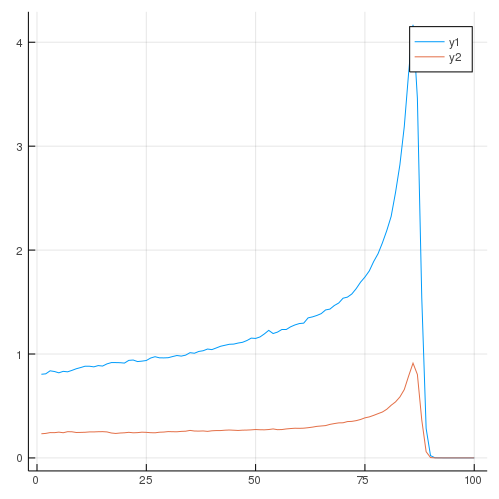

In [11]:
en = 120
plot(collect(range(1, stop=100)), [K_cont(en, y_) for y_ in collect(range(1, stop=100))])
plot!(collect(range(1, stop=100)), [K_another(en, y_) for y_ in collect(range(1, stop=100))])

In [12]:
sig = 0.01*f_y + [max(sqrt(i), 1) for i in f_y]
f = f_y;
# plot(f_y, ribbon=sig, fillalpha=0.3, xlabel="y", ylabel="f_y", label="", dpi=400,
#     xtickfontsize=18,ytickfontsize=18, legendfontsize=18, guidefont=font(18), color = :blue)
# savefig("f_y_cont.png")

In [13]:
basis = CubicSplineBasis(1, 150, 60, (nothing, "dirichlet"));
Omega = omega(basis);
model = GaussErrorUnfolder(basis, [Omega], "User", alphas=[0.1440379000137214]);

┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:107
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140
┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:161


In [14]:
@time result = solve(model, K_cont, f, sig, collect(range(1, stop=100)));
@time result_another = solve(model, K_another, f, sig, collect(range(1, stop=100)));

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44
┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:105
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:202


 47.805195 seconds (1.10 G allocations: 28.778 GiB, 20.82% gc time)


┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44


138.060234 seconds (2.90 G allocations: 54.888 GiB, 16.37% gc time)


┌ Info: Kernel was discretized successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:55
┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:86
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:105
┌ Info: Ending solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:202


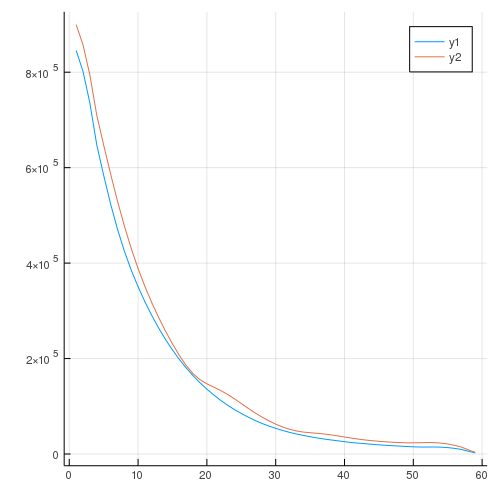

In [15]:
plot(result["coeff"] * 3.1)
plot!(result_another["coeff"])

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


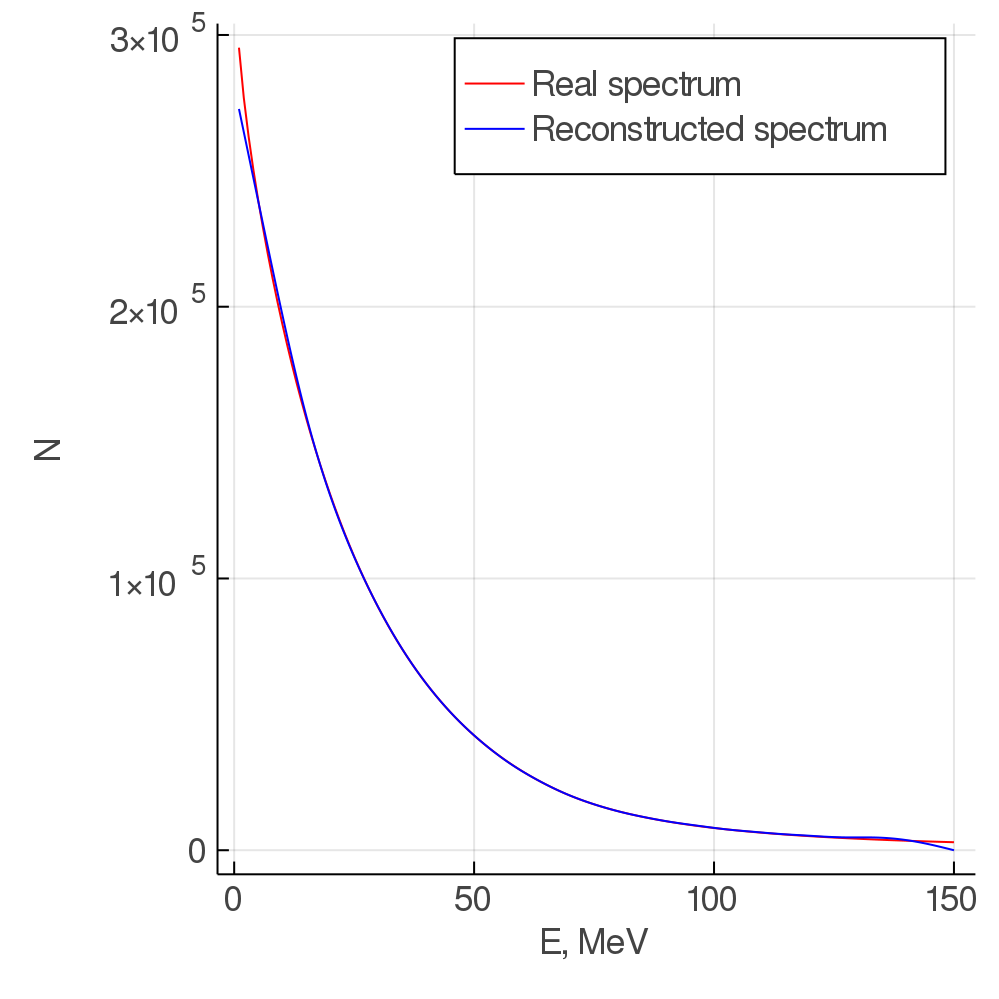

In [21]:
x = collect(range(1, 150, length=500))
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(collect(range(1, stop=150)), arr_spectrum_real, label="Real spectrum", color=:red)
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="E, MeV", ylabel="N", color = :blue,
    xtickfontsize=12,ytickfontsize=12, legendfontsize=12, guidefont=font(12), dpi=200)
# savefig("gaussian.png")

0.047816872160671216

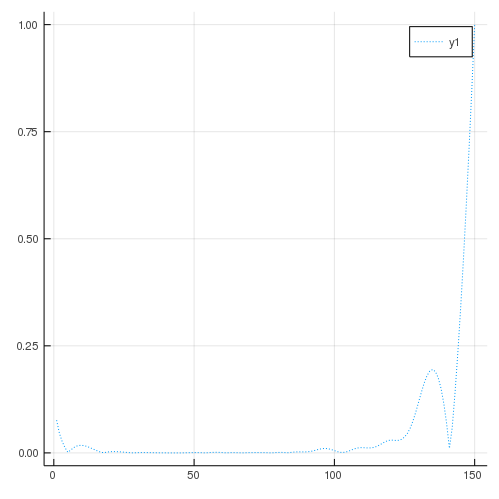

In [17]:
arr_rec = phivec.phi_function.(energy)
for_plot = [abs(arr_rec[i]-arr_spectrum_real[i])/arr_spectrum_real[i] for i in range(1, stop=length(arr_rec))]
print(mean(for_plot))
plot(for_plot, linestyle=:dot)

┌ Info: PhiVec is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solution_utils/vector.jl:64


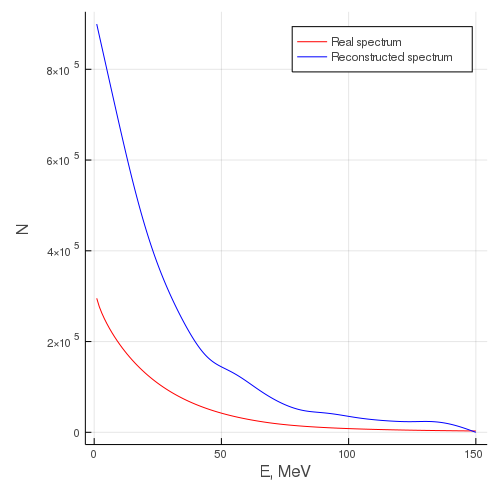

In [18]:
x = collect(range(1, 150, length=500))
phivec_another = PhiVec(result_another, basis)

phi_reconstructed_another = phivec_another.phi_function.(x)
phi_reconstructed_errors_another = phivec_another.error_function.(x)

plot(collect(range(1, stop=150)), arr_spectrum_real, label="Real spectrum", color=:red)
plot!(x, phi_reconstructed_another, ribbon=phi_reconstructed_errors_another, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="E, MeV", ylabel="N", color = :blue)
#     xtickfontsize=12,ytickfontsize=12, legendfontsize=12, guidefont=font(12), dpi=200)
# savefig("reconstructed_cont.png")

2.890672550410016

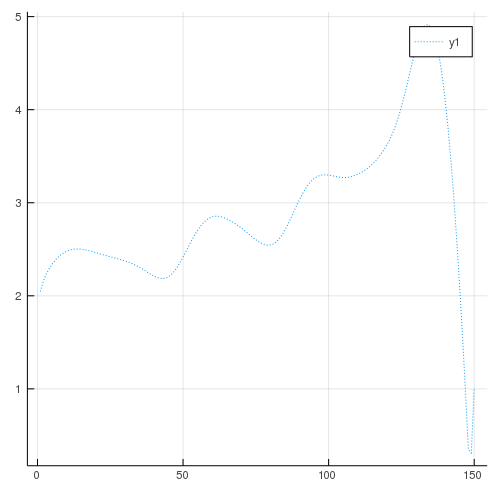

In [19]:
arr_rec_another = phivec_another.phi_function.(energy)
for_plot_another = [abs(arr_rec_another[i]-arr_spectrum_real[i])/arr_spectrum_real[i] for i in range(1, stop=length(arr_rec_another))]
print(mean(for_plot_another))
plot(for_plot_another, linestyle=:dot)

In [20]:
plot(phi_reconstructed_another / sum(phi_reconstructed_another)[1:end-1])
plot!(phi_reconstructed / sum(phi_reconstructed))

MethodError: MethodError: no method matching getindex(::Float64, ::UnitRange{Int64})
Closest candidates are:
  getindex(::Number) at number.jl:75
  getindex(::Number, !Matched::Integer) at number.jl:77
  getindex(::Number, !Matched::Integer...) at number.jl:82
  ...